<a href="https://colab.research.google.com/github/plaban1981/Hackathon_Learnings/blob/master/Predict_term_insurance_enrollment_AV_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Marketing DataSet - Intelligent Targeting**

Marketing campaigns are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. Some important aspects of a marketing campaign are as follows: 

**Segment of the Population:** To which segment of the population is the marketing campaign going to address and why? This aspect of the marketing campaign is extremely important since it will tell to which part of the population should most likely receive the message of the marketing campaign. 

**Distribution channel to reach the customer's place:** Implementing the most effective strategy in order to get the most out of this marketing campaign. What segment of the population should we address? Which instrument should we use to get our message out? (Ex: Telephones, Radio, TV, Social Media Etc.) 

**Promotional Strategy:** This is the way the strategy is going to be implemented and how are potential clients going to be address. This should be the last part of the marketing campaign analysis since there has to be an in-depth analysis of previous campaigns (If possible) in order to learn from previous mistakes and to determine how to make the marketing campaign much more effective.

You are leading the marketing analytics team for a banking institution. There has been a revenue decline for the bank and they would like to know what actions to take. After investigation, it was found that the root cause is that their clients are not depositing as frequently as before. Term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can lend more and thus make more profits. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues.

You are provided a dataset containing details of marketing campaigns done via phone with various details for customers such as demographics, last campaign details etc. Can you help the bank to predict accurately whether the customer will subscribe to the focus product for the campaign - Term Deposit after the campaign?

## Data Description

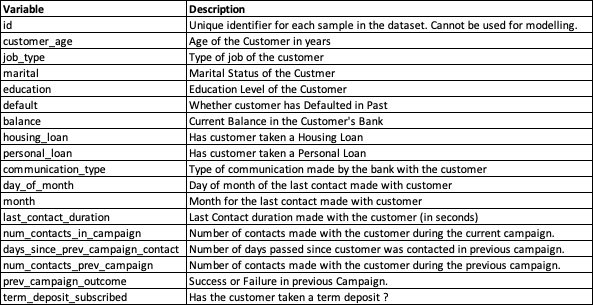

* We can see that variables 1 to 16 can be used for modelling. 
* Variable '**id**' is Identifier column. It has a unique value for every sample in the dataset and cannot be used for modelling.
* Variable '**term_deposit_subscribed**' is Target/y column. It has binary values and we need to learn to predict this variable given our above 16 variables as features.

#### **Hypothesis Generation**
Simply put, a hypothesis is a possible view or assertion of an analyst about the problem he or she is working upon. It may be true or may not be true.

* Are younger customers more likely to subscribe to a term deposit as compared to old customers ?

* Are people with a higher bank balance more likely subscribe to term deposit than people with low balance ?

* Does a married person have higher chances to subscribe to a term deposit compared to a single or divorced person ? 

* Does the length of the call made to the customers tell us anything about their chances of subscribing ?
(One may think that if the call length is longer, the customer executive has spent a longer time, discussing details with customer, hence the customer is more likely to subscribe).

In [1]:
!pip install catboost

     |████████████████████████████████| 66.1MB 67kB/s 


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [3]:
train = pd.read_csv("/content/Train_eP48B9k.csv")
test = pd.read_csv("/content/Test_jPKyvmK.csv")

In [4]:
train.head()

id  customer_age  ... prev_campaign_outcome term_deposit_subscribed
0  id_43823  28.0          ...  unknown               0                     
1  id_32289  34.0          ...  other                 0                     
2  id_10523  46.0          ...  unknown               0                     
3  id_43951  34.0          ...  unknown               0                     
4  id_40992  41.0          ...  unknown               0                     

[5 rows x 18 columns]

In [5]:
test.head()

id  customer_age  ... num_contacts_prev_campaign prev_campaign_outcome
0  id_17231  55.0          ...  0                          unknown             
1  id_34508  24.0          ...  0                          unknown             
2  id_44504  46.0          ...  0                          unknown             
3  id_174    56.0          ...  0                          unknown             
4  id_2115   62.0          ...  1                          success             

[5 rows x 17 columns]

In [4]:
ss = pd.read_csv('/content/SampleSubmission_XkIpo3X.csv')
ss.head()

id  term_deposit_subscribed
0  id_17231  0                      
1  id_34508  0                      
2  id_44504  0                      
3  id_174    0                      
4  id_2115   0

# Data insights

# Target Distribution 

This is a binary classification problem. Lets have a look at the number of positive and negative examples that we have, or in our problem statement terms: '*Number of People who did subscribe for a term deposit and the number of people who did not'*

In [5]:
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'

In [8]:
train[TARGET_COL].value_counts(normalize=True)

0    0.892754
1    0.107246
Name: term_deposit_subscribed, dtype: float64

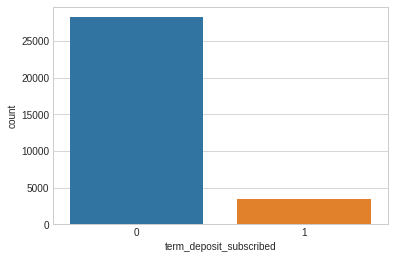

In [9]:
sns.countplot(train[TARGET_COL])
plt.show()

The people subscribed to term insurance deposit is only 10%.
The dataset is highly imbalanced.

In [6]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 31647 samples and 18 variables

Test contains 13564 samples and 17 variables

The dataset contains 16 features


#### **Variable Datatypes**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

#### **Check for NULL values**

In [ ]:
null_values_per_variable = 100 *(train.isnull().sum()/train.shape[0]).round(3)
null_values_per_variable.sort_values(ascending= False)

days_since_prev_campaign_contact    81.6
customer_age                        2.0 
balance                             1.3 
last_contact_duration               1.0 
personal_loan                       0.5 
marital                             0.5 
num_contacts_in_campaign            0.4 
job_type                            0.0 
education                           0.0 
default                             0.0 
term_deposit_subscribed             0.0 
housing_loan                        0.0 
prev_campaign_outcome               0.0 
communication_type                  0.0 
day_of_month                        0.0 
month                               0.0 
num_contacts_prev_campaign          0.0 
id                                  0.0 
dtype: float64

#### **Unique values in each variable**

In [ ]:
train.nunique()

id                                  31647
customer_age                           77
job_type                               12
marital                                 3
education                               4
default                                 2
balance                              6563
housing_loan                            2
personal_loan                           2
communication_type                      3
day_of_month                           31
month                                  12
last_contact_duration                1447
num_contacts_in_campaign               46
days_since_prev_campaign_contact      511
num_contacts_prev_campaign             41
prev_campaign_outcome                   4
term_deposit_subscribed                 2
dtype: int64

#### **Analyzing each variable and their relationship**

There are two types of features that we have:

1. Categorical
2. Numerical

Also our target is Binary

For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time

2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'term_deposit_subscribed'


But before jumping straight into analysis, lets have a look at the variables we had and try to ask some questions ourselves

**Categorical values**

In [11]:
cat_cols = [cols for cols in train.columns if train[cols].dtypes == 'O' and cols not in [ID_COL,TARGET_COL]]

In [12]:
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

#### **Numerical varaibales**

In [13]:
num_cols = [c for c in train.columns if c not in cat_cols and train[c].dtypes != 'O' and c !='term_deposit_subscribed']
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

# EDA


Before going to any kind of modelling, we will always want to have a look at the kind of data that we have.  

We have been provided three files. A description for what each of these files contain is given below:


1.     **SampleSubmission.csv**: This gives us a required format for submitting our solutions to the AV solution checker.
2.     **Train.csv**: We will use this file for training our model. It contains variables or features that we will input to our model, and the *target variable* that we want to predict.
3.     **Test.csv**: This will contain all variables in the training dataset except the *target variable*. We will use our trained model to predict the target for this dataset. 




# Install Automatic Visualization Tool - Visualizer

In [ ]:
pip install visualizer

     |████████████████████████████████| 368kB 3.9MB/s 
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


#### **Univariate Analysis - Pie Charts.**

Pie Charts can be useful in seeing the proportion of samples, that fall into each category of a categorical variable. For each of the categorical variables we will make a pie chart.

In [ ]:
cat_cols

['id',
 'job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

# Automating Visualization  using Visualizer

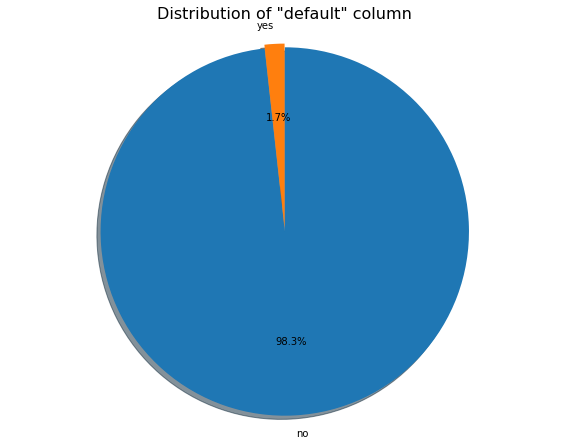

In [ ]:
Visualizer.create_pie_plot(df=train, cat_col='default')

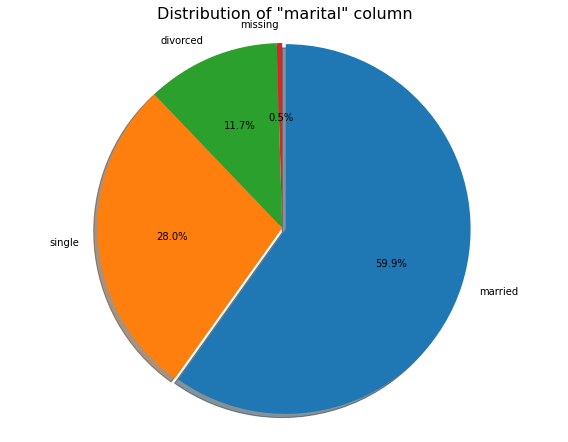

In [ ]:
df = train.fillna('missing')
Visualizer.create_pie_plot(df=df, cat_col='marital')

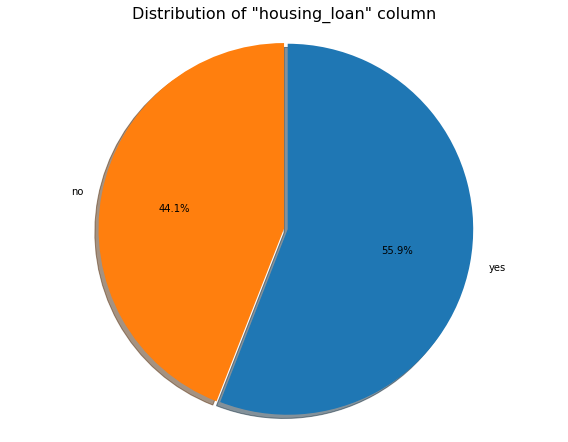

In [ ]:
Visualizer.create_pie_plot(df=train, cat_col='housing_loan')

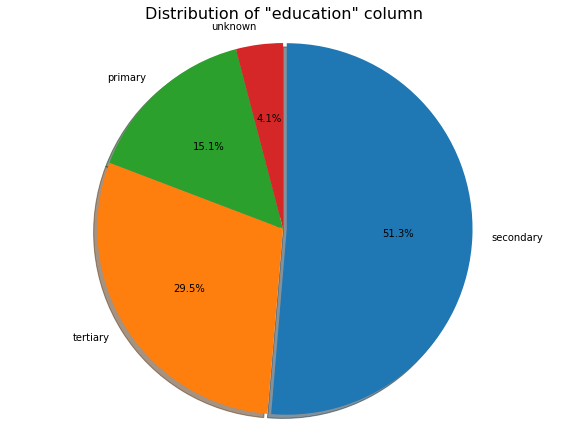

In [ ]:
Visualizer.create_pie_plot(df=train, cat_col='education')

# Using Matplotlib

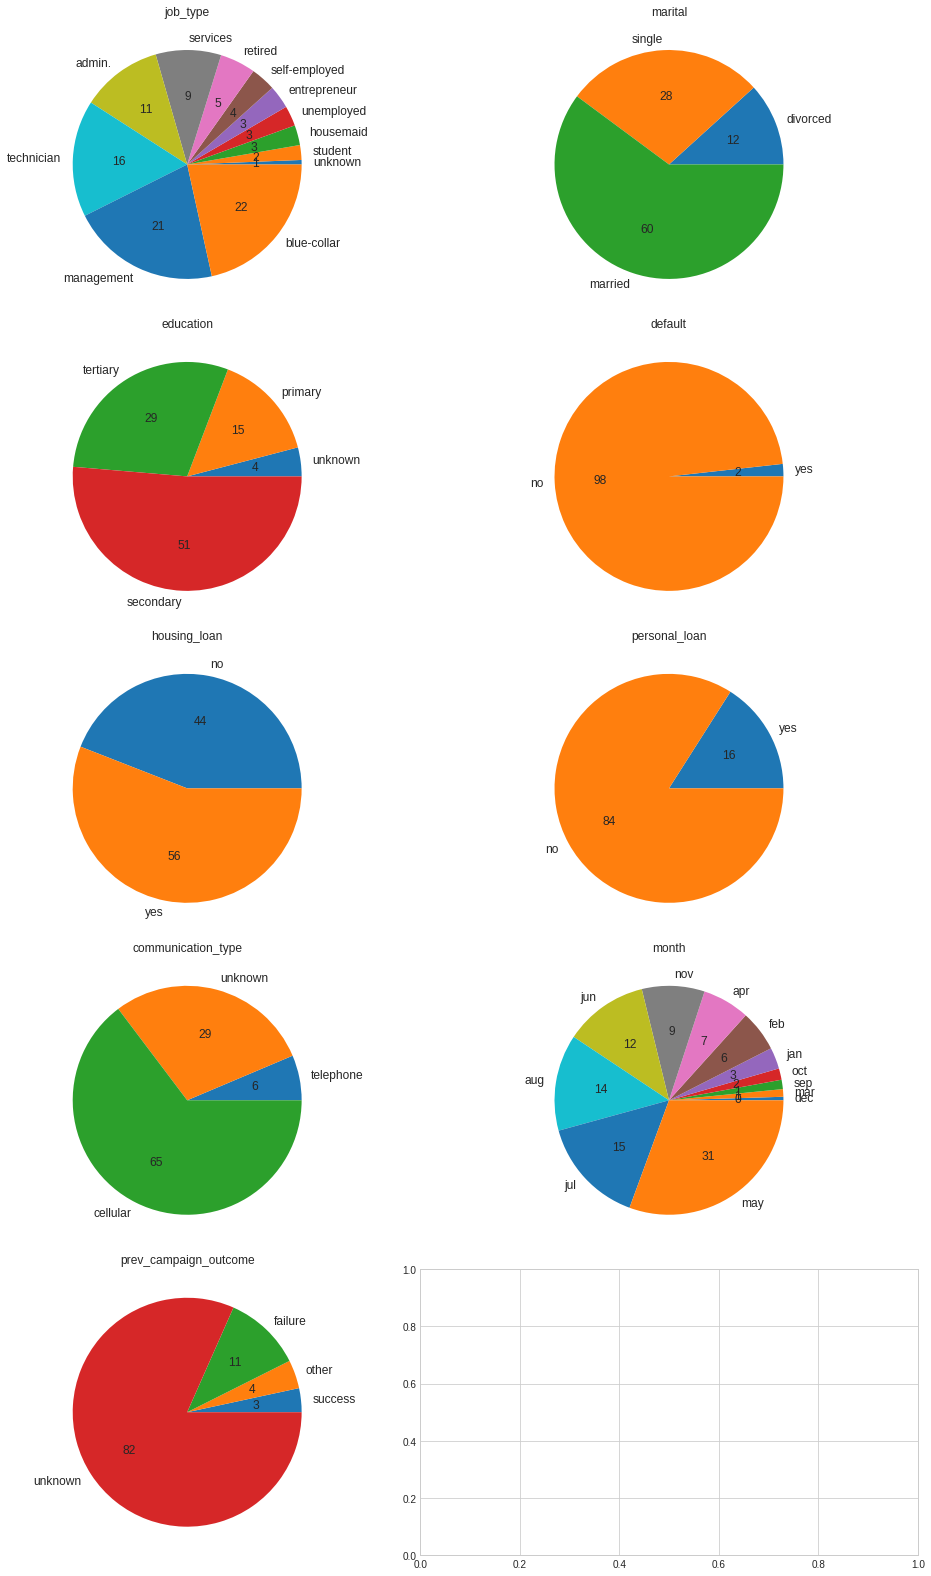

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

#### **Univariate Analysis - CountPlots**
Another way of looking at the counts of each of the categories is countplots. These are similar to barplots with the width of the bars representing the count of the category in the variable

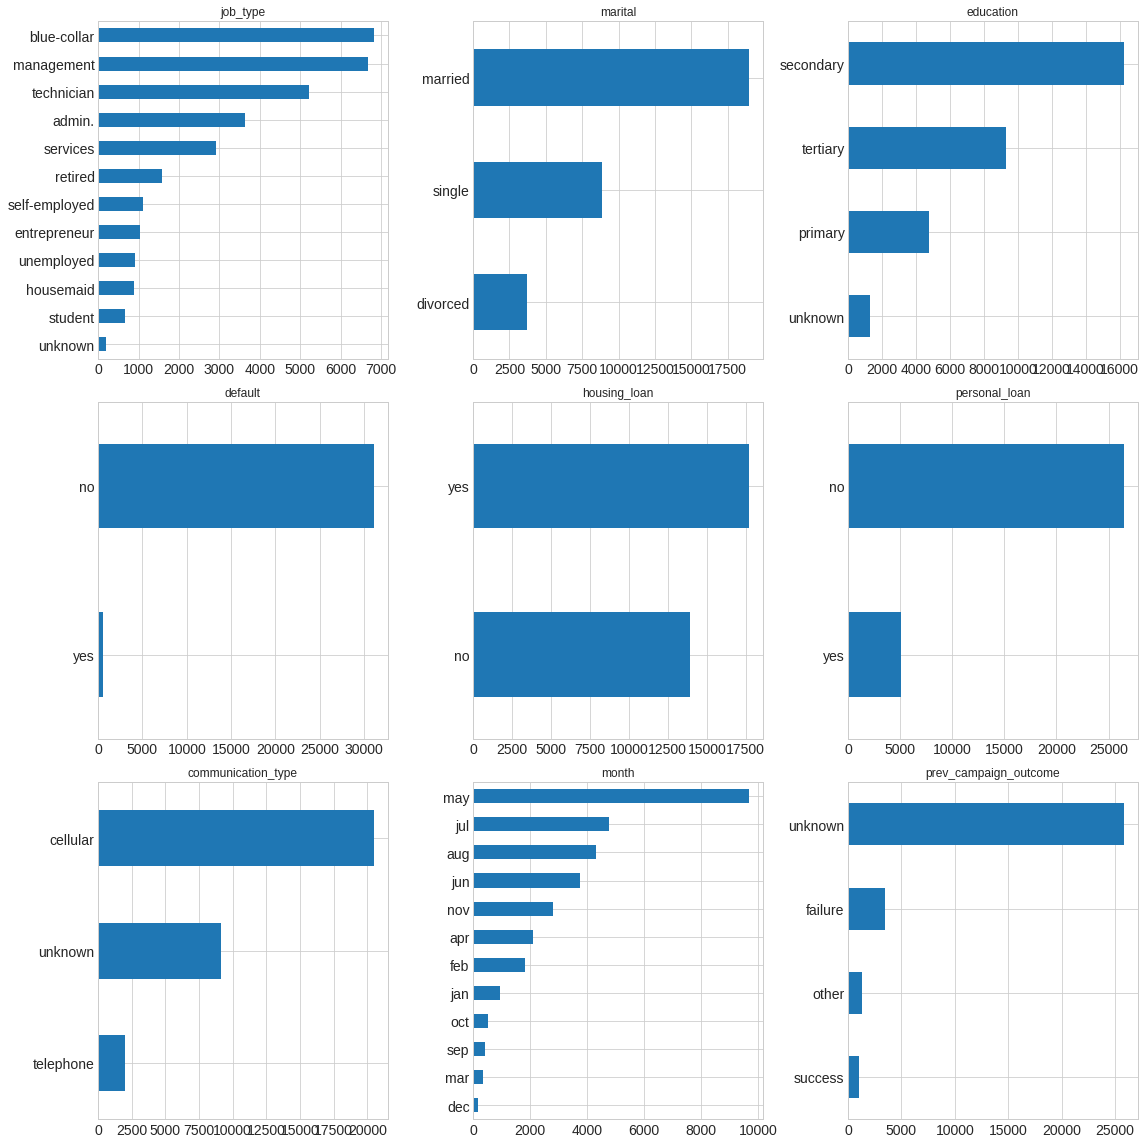

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

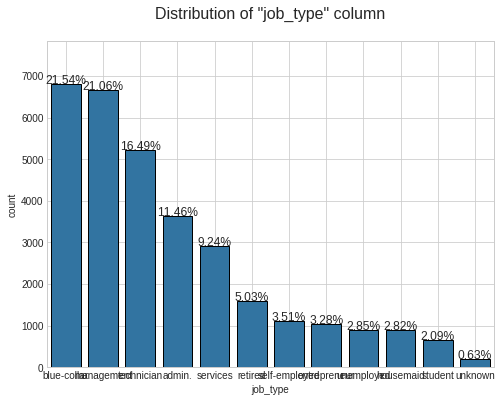

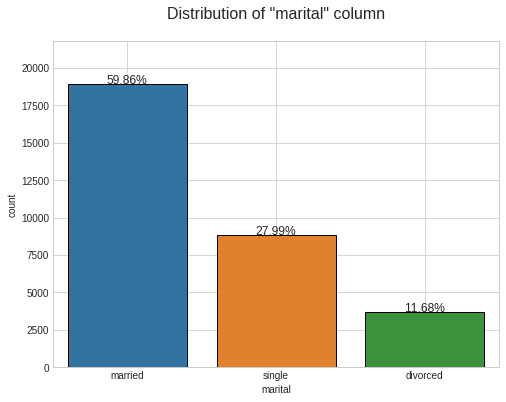

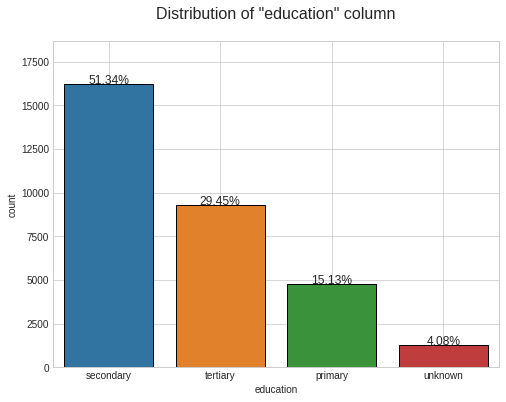

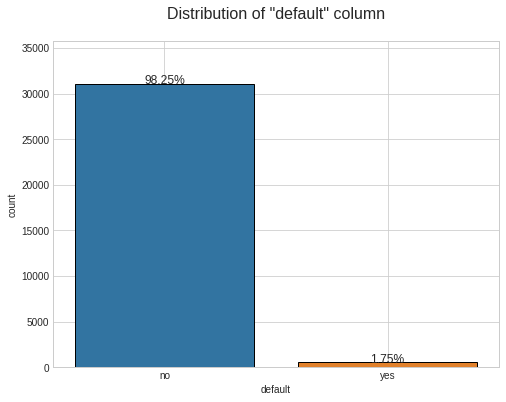

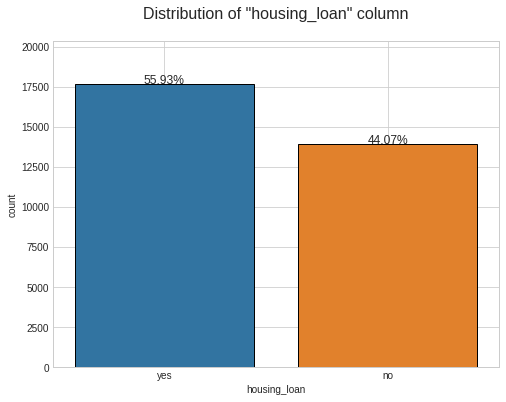

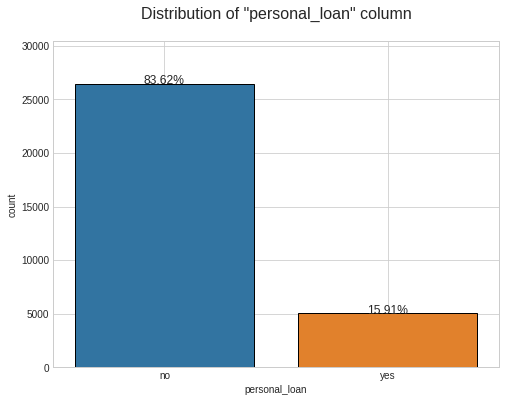

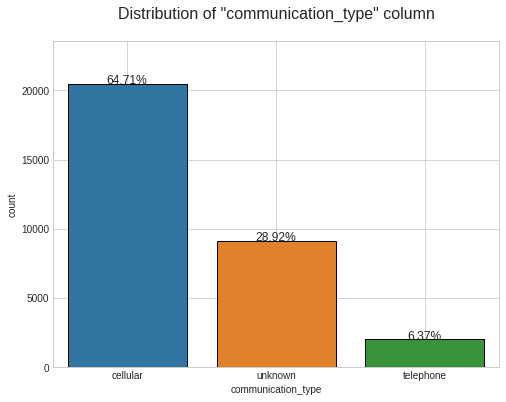

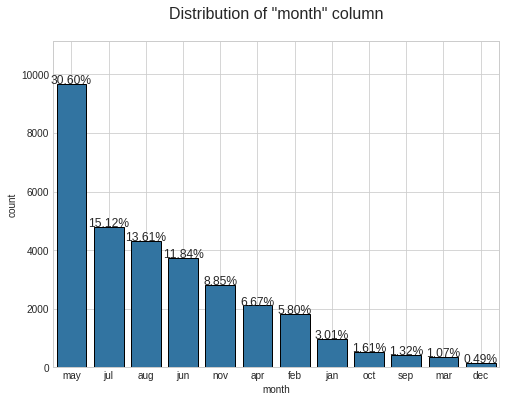

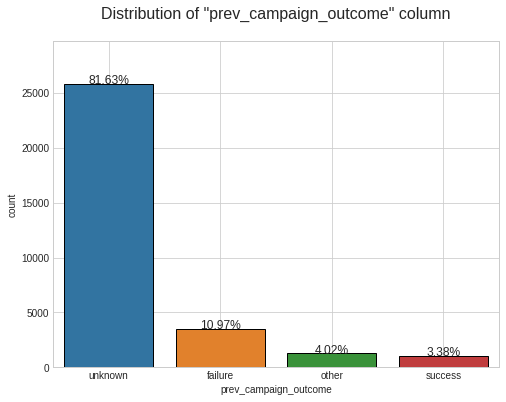

In [ ]:
for col in cat_cols :
  Visualizer.create_count_plot(df=train, cat_col=col, annot=True)
  plt.show()

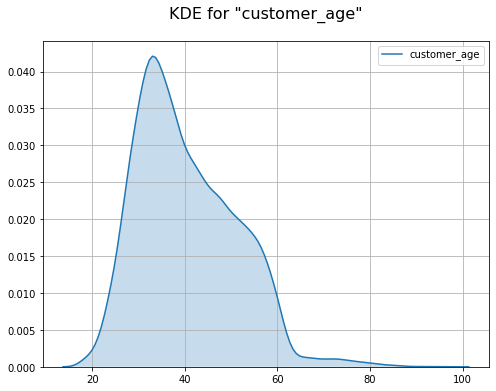

In [ ]:
Visualizer.create_kde_plot(df=train, num_col='customer_age')

#### **Bivariate Analysis Relationships with Target**

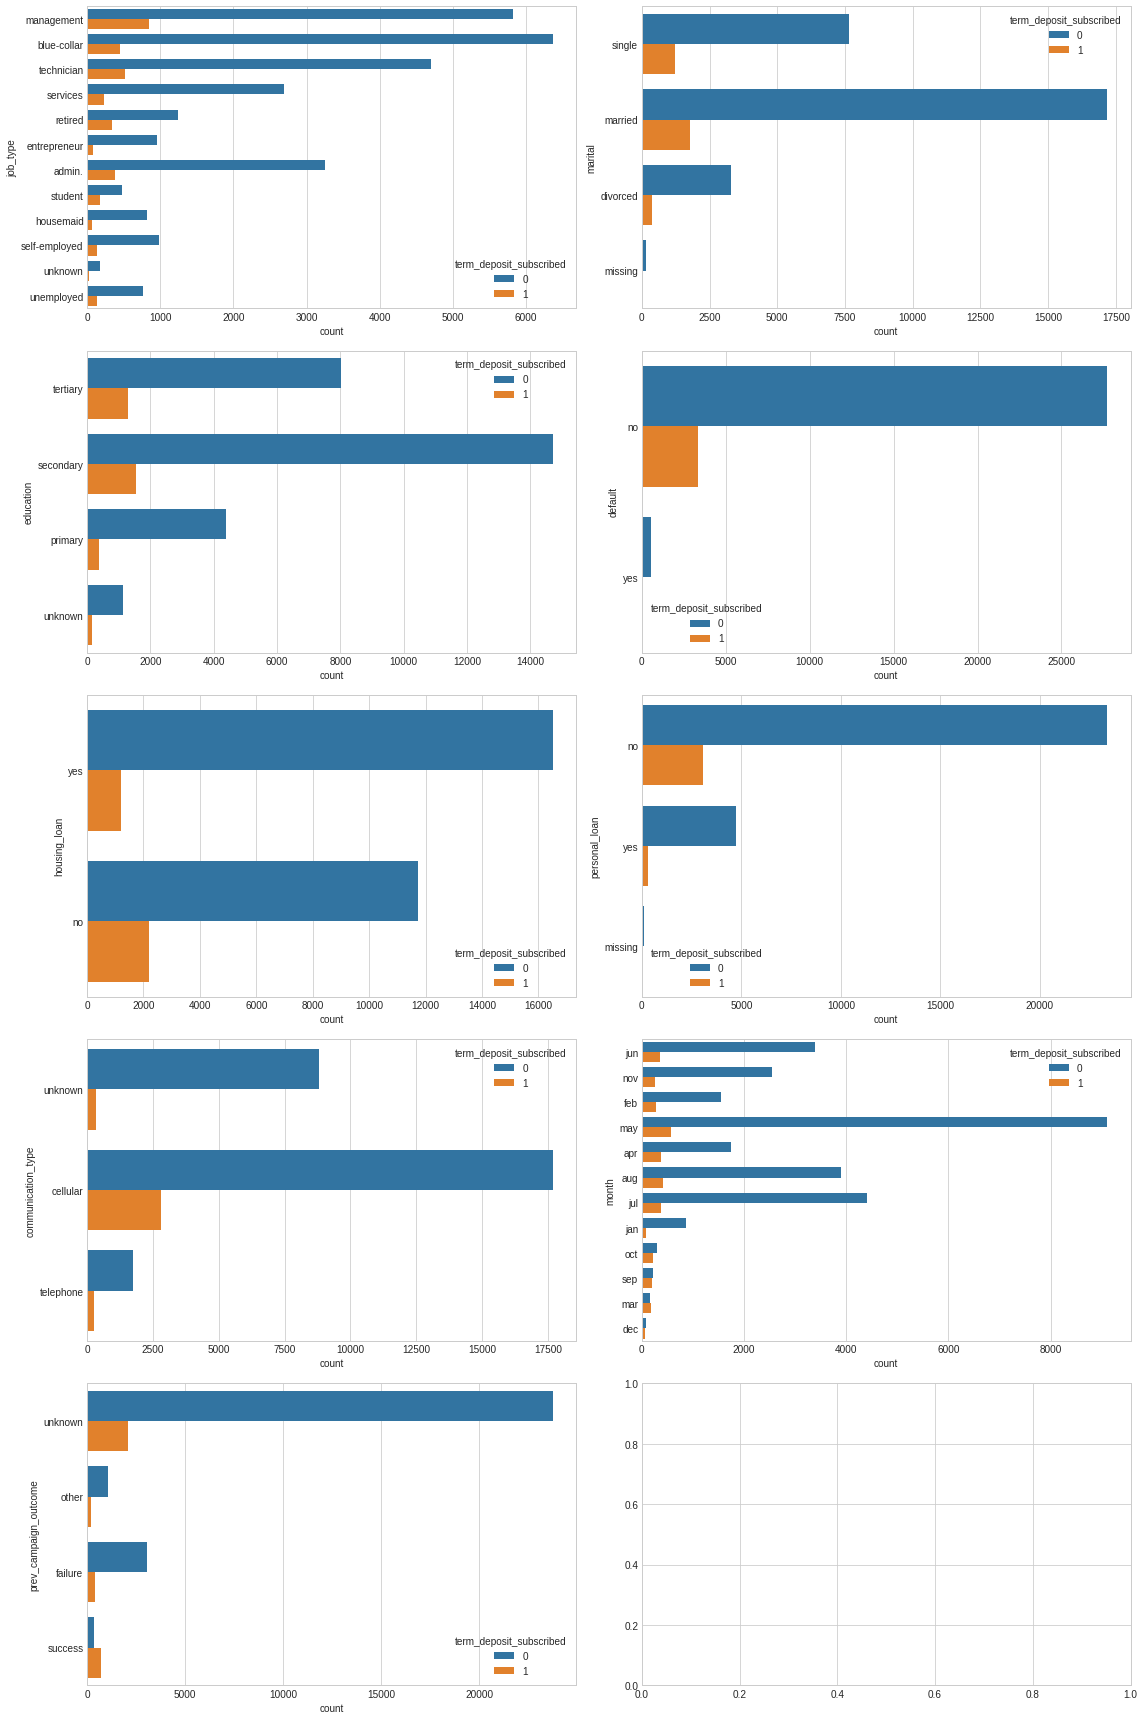

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]
for i,col in enumerate(cat_cols):
  fltr = train[TARGET_COL] == 0
  g_0 = train[fltr][col].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)
  g_0[TARGET_COL] = 0
  #print(g_0)
  g_1 = train[~fltr][col].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)
  #print(g_1)
  g_1[TARGET_COL] = 0
  final = pd.concat([g_0,g_1]).reset_index(drop=True)
  sns.countplot(y=col,data=df,hue=TARGET_COL,ax=axes[i])

plt.tight_layout()
plt.show()

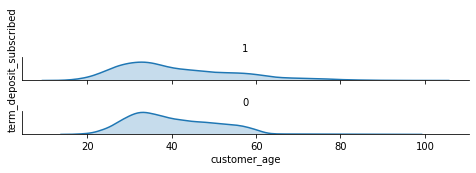

In [ ]:
Visualizer.create_ridge_plot(df=train, num_col="customer_age", cat_col='term_deposit_subscribed')

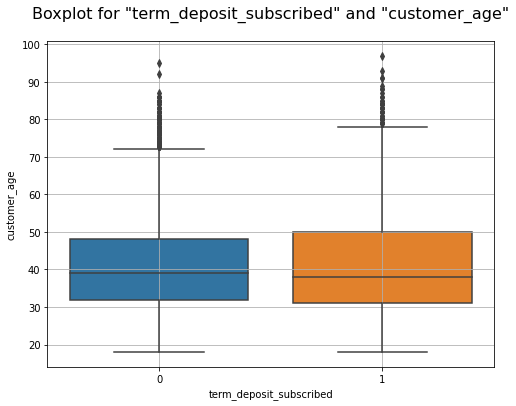

In [ ]:
Visualizer.create_box_plot(df=train, num_col="customer_age", cat_col='term_deposit_subscribed')

**Q. Do married people have more chances of subscribing to a term deposit ?**

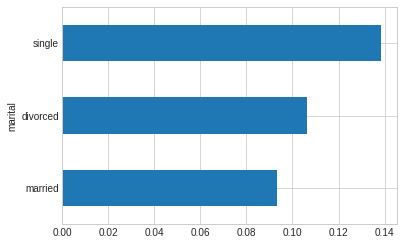

In [ ]:
train.groupby('marital')[TARGET_COL].mean().sort_values().plot(kind='barh')
plt.show()

**Q. Do people having no personal loan have more chances of subscribing to a term deposit ?**

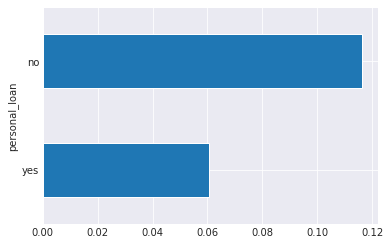

In [ ]:
sns.set_style('darkgrid')
train.groupby('personal_loan')[TARGET_COL].mean().sort_values().plot(kind='barh')
plt.show()

**Q. Do people having no housing loan have more chances of subscribing to a term deposit ?**

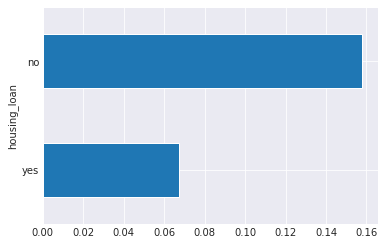

In [ ]:
#sns.set_style('darkgrid')
train.groupby('housing_loan')[TARGET_COL].mean().sort_values().plot(kind='barh')
plt.show()

**Q. What is the best communication type to be used to have more chances of subscribing to a term deposit ?**

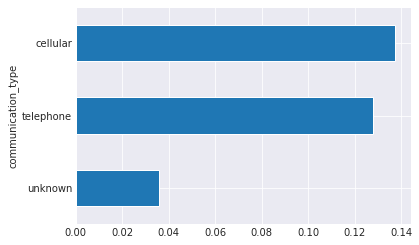

In [ ]:
#sns.set_style('darkgrid')
train.groupby('communication_type')[TARGET_COL].mean().sort_values().plot(kind='barh')
plt.show()

The data tells us quite a different story than our initial thought process, single people are the more likely to subscribe to a term deposit.

## Numerical value boxplots

##### 1. **Univariate Analysis - Boxplots**

Boxplot can be used to see the spread of the numerical variables, and identify outliers

https://en.wikipedia.org/wiki/Box_plot

Pearson correlation / spearman corelation applied to only numerical variables

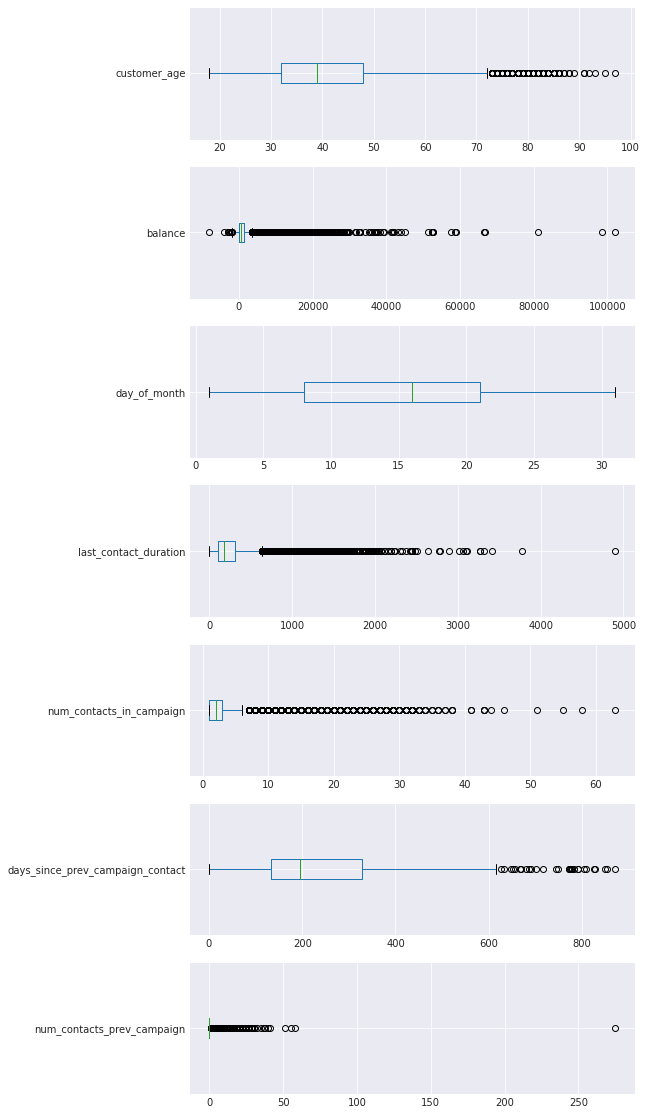

In [ ]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

##### **2. Univariate Analysis - Density Plots**

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

In [ ]:
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

In [ ]:
tf = train[num_cols].fillna(0)

In [ ]:
tf.isnull().sum()

customer_age                        0
balance                             0
day_of_month                        0
last_contact_duration               0
num_contacts_in_campaign            0
days_since_prev_campaign_contact    0
num_contacts_prev_campaign          0
dtype: int64

In [ ]:
tf.columns

Index(['customer_age', 'balance', 'day_of_month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign'],
      dtype='object')

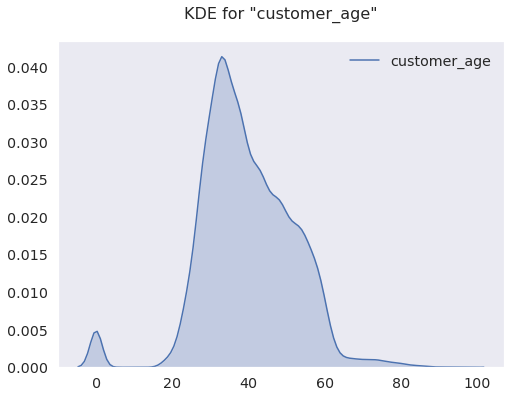

In [ ]:
Visualizer.create_kde_plot(df=tf, num_col='customer_age')

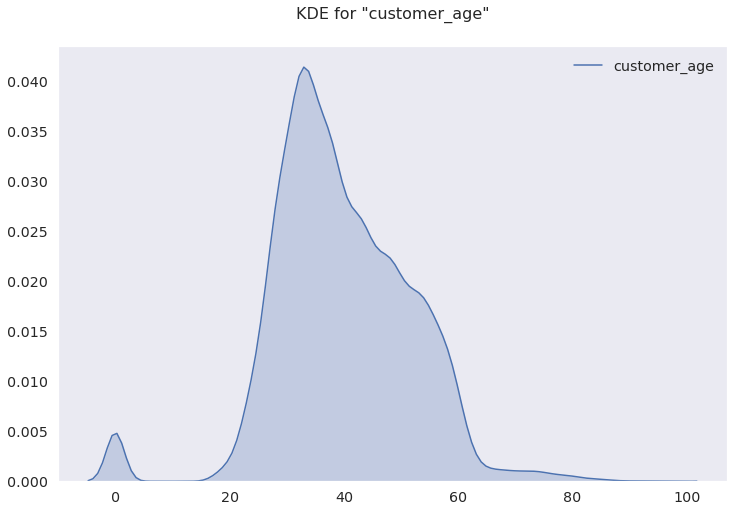

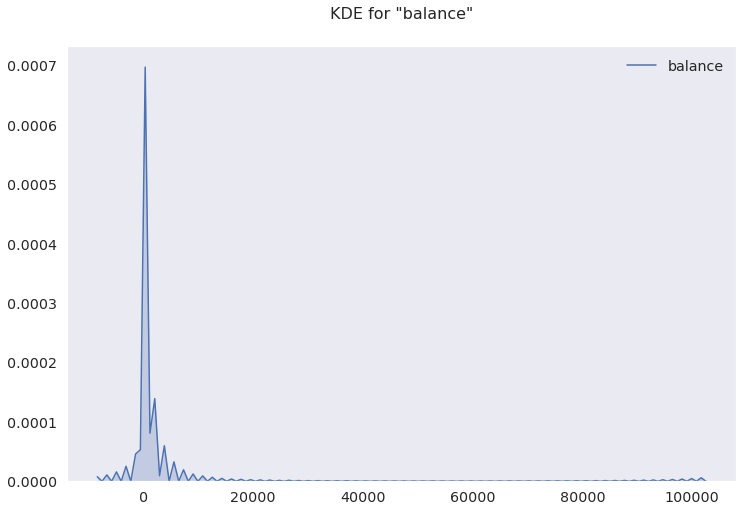

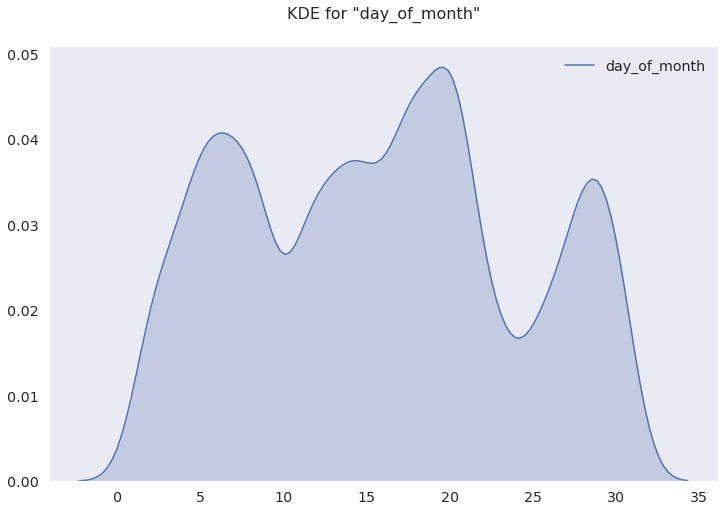

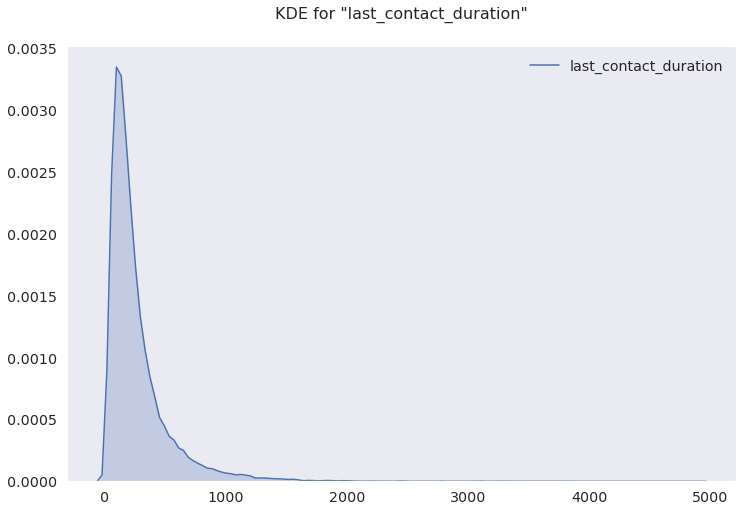

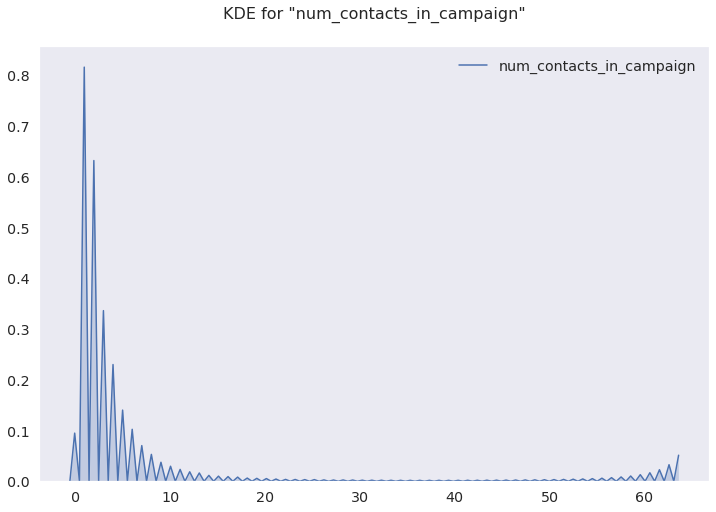

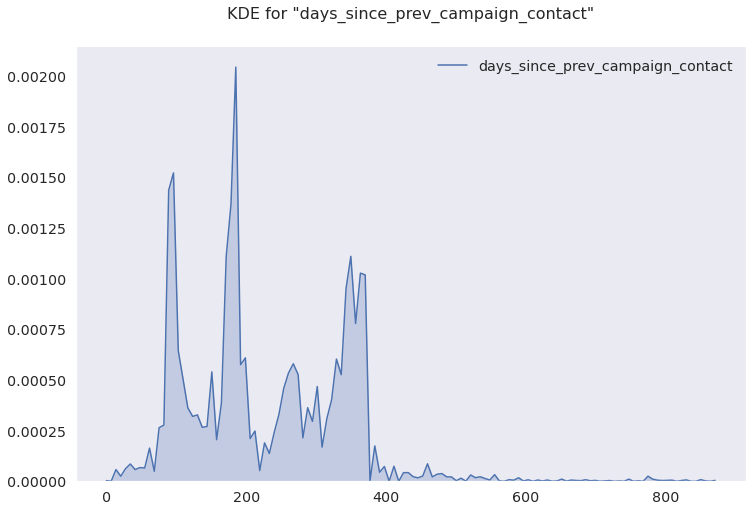

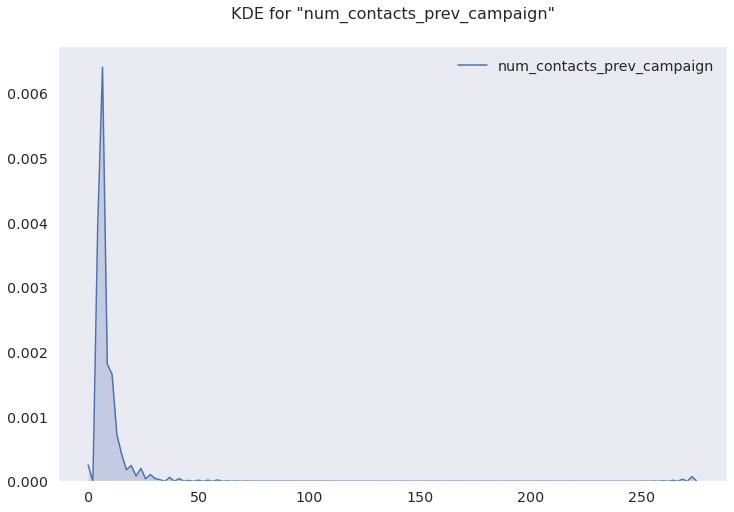

<Figure size 432x288 with 0 Axes>

In [ ]:
for i, c in enumerate(num_cols):
  #plot = sns.kdeplot(data=tf, x=c, ax=axes[i], fill=True)
  Visualizer.create_kde_plot(df=tf, num_col=c,figsize=(12,8))
plt.tight_layout()

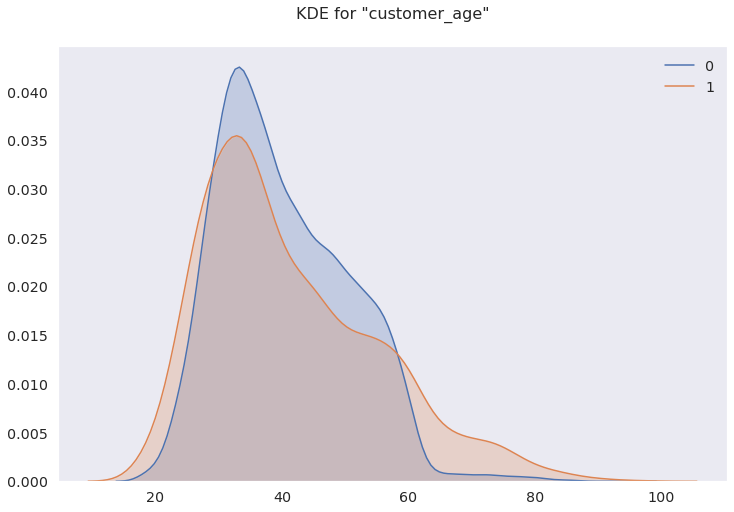

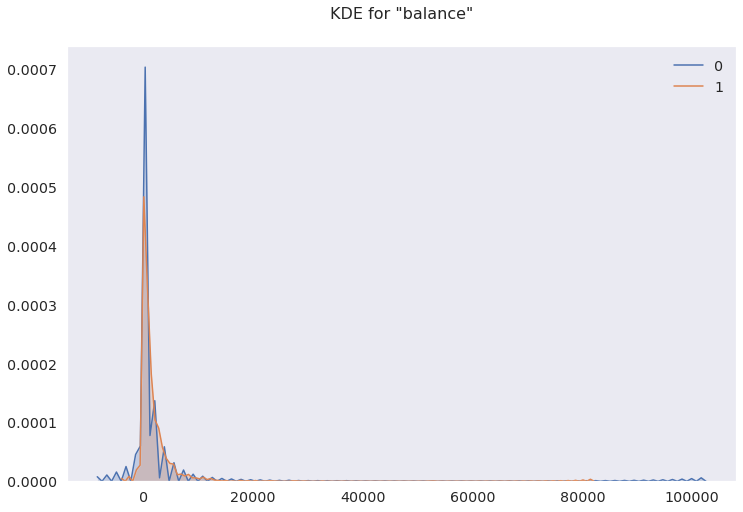

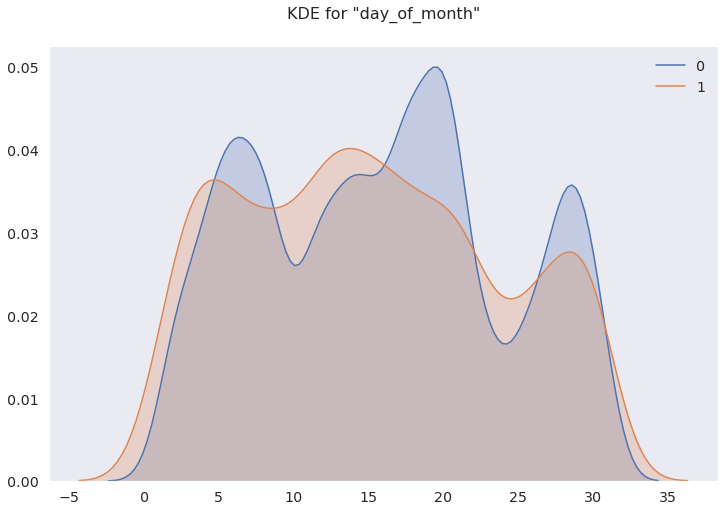

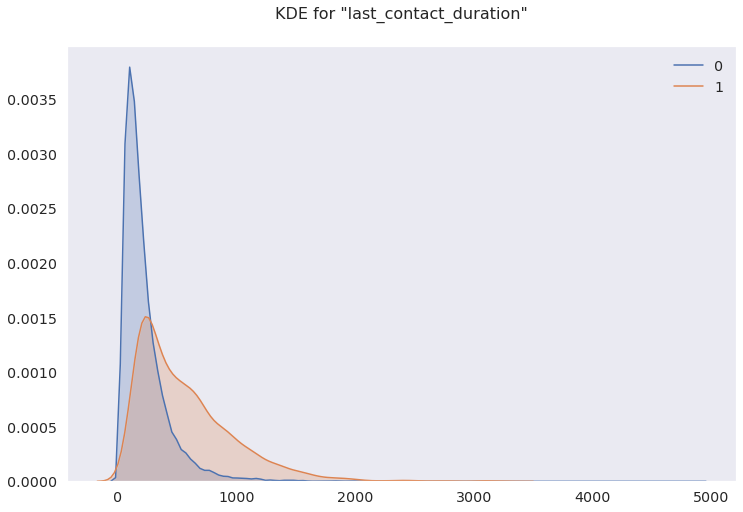

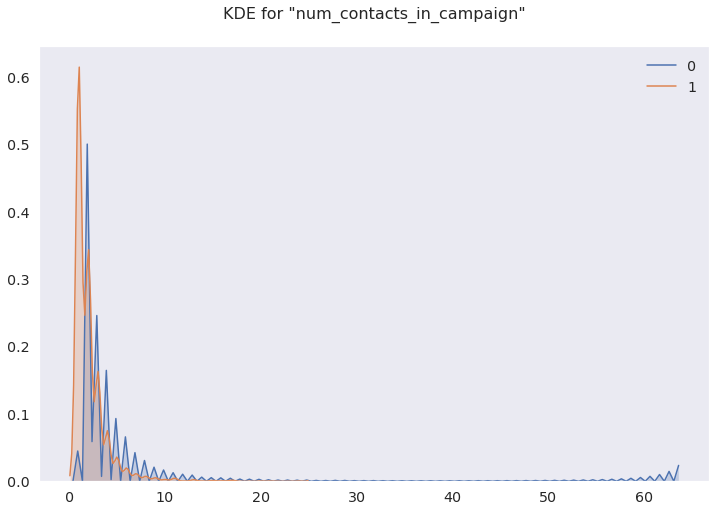

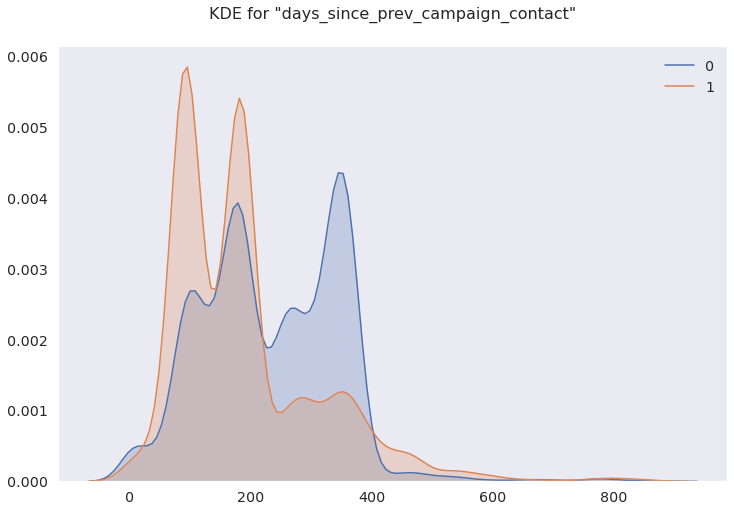

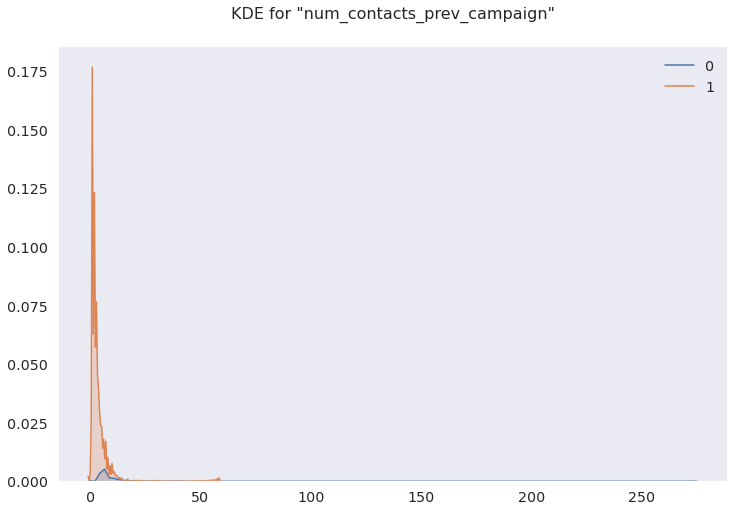

<Figure size 432x288 with 0 Axes>

In [ ]:
for i, c in enumerate(num_cols):
  Visualizer.create_kde_plot(df=train, num_col=c,target_col=TARGET_COL,figsize=(12,8))
  
plt.tight_layout()

##### **4. Bivariate Analysis - Horizontal BarPlots**

For each numerical Variable. We will plot the median of the numerical variable for:


1. When term_deposit_subscribed == 0
2. when term_deposit_subscribed == 1

**We are choosing median since median is not affected by outliers**, and our data has a lot of outlers

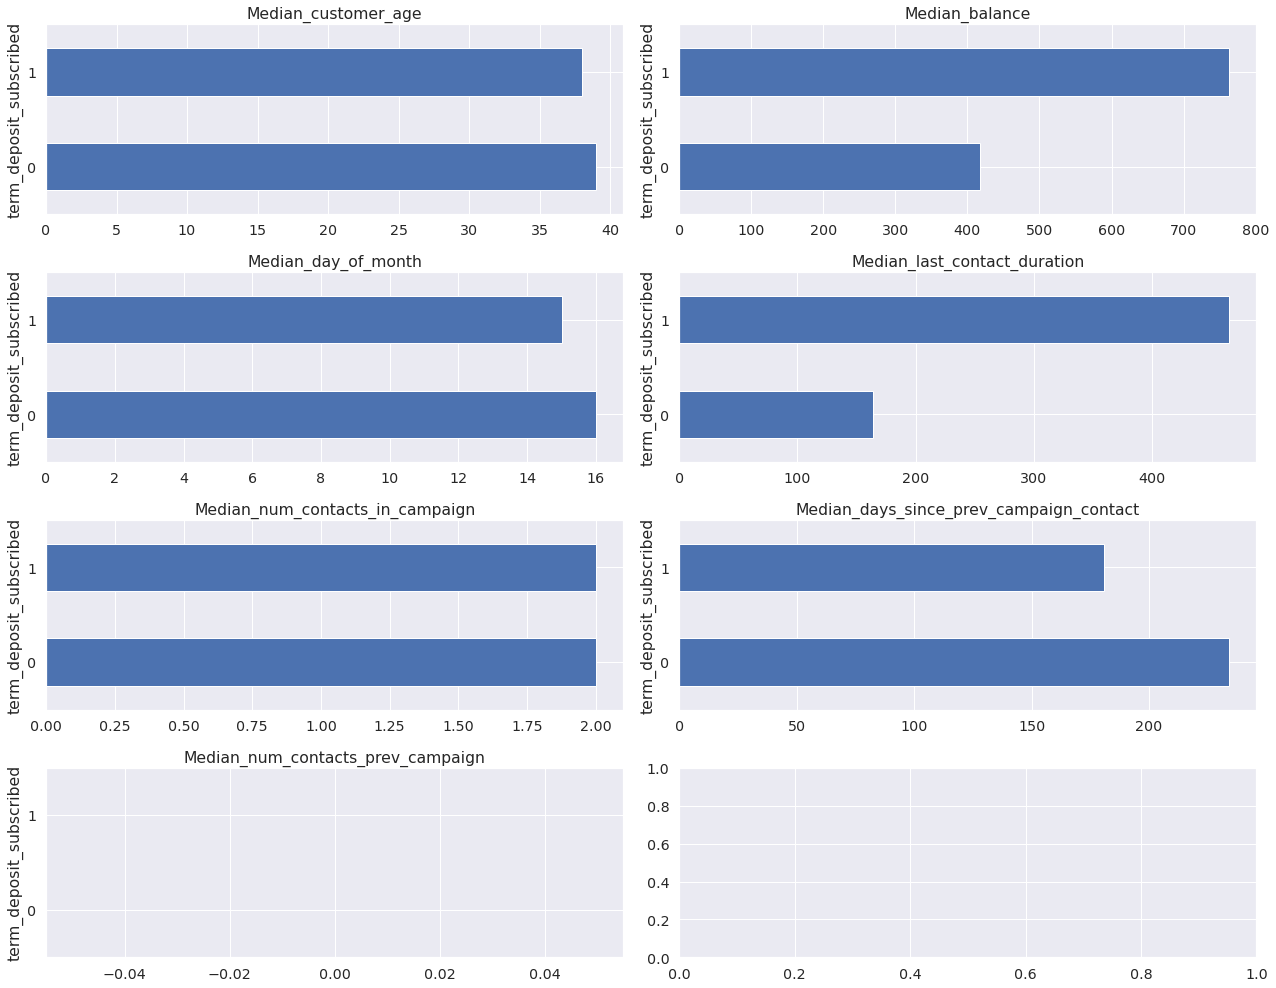

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

**Q. Do people with a higher bank balance more likely subscribe to term deposit than people with low balance ?**

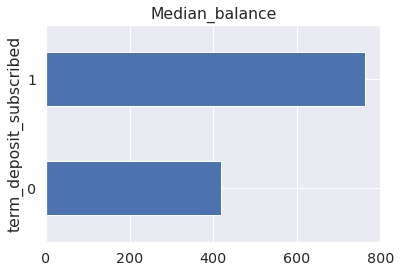

In [ ]:
train.groupby(TARGET_COL)['balance'].median().plot(kind = 'barh', title=f'Median_balance')

If you see the plot above median balance of customers not subscribing to a term deposit is around 400 whereas median balance of customers subscribing to a term deposit is 800. This definitely supports our initial hypothesis.

**Q. Does the length of the call made to the customers tell us anything about their chances of subscribing ?**

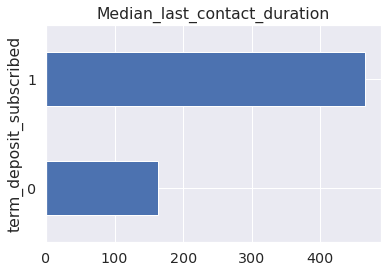

In [ ]:
train.groupby(TARGET_COL)['last_contact_duration'].median().plot(kind = 'barh', title=f'Median_last_contact_duration')

From the plot above median last_call_duration made to the customers not subscribing to a term deposit is around 150 seconds. Median last_call_duration made to the customers subscribing to a term deposit is around 450 seconds. So yes our hypothesis seems true.

**Q. Are younger customers more likely to subscribe to a term deposit compared to old customers ?**

It's not very clear from our above plot since we have median age of around 40 for both cases

Lets dig deeper.

We will define:
 old as Age > 60
 Not Old as Age <= 60

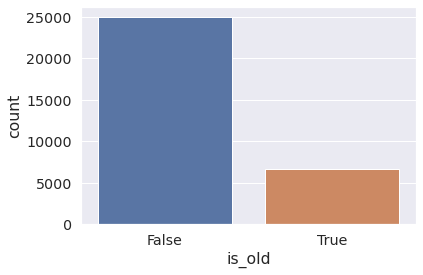

In [ ]:
train['is_old'] = True
train.loc[train['customer_age'] <= 50, 'is_old'] = False
sns.countplot(train['is_old'])

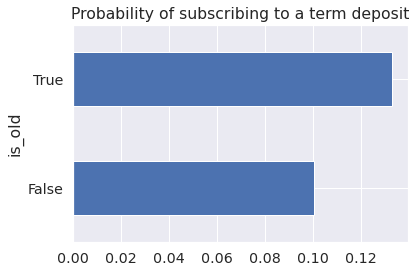

In [ ]:
train.groupby('is_old')[TARGET_COL].mean().sort_values().plot(kind = 'barh', title='Probability of subscribing to a term deposit')

Looks like old age customers are definitely more likely to subscribe to a term deposit compared to younger age customers

##### **5. Bivariate Analysis - Correlation Heatmaps**

<Figure size 1008x576 with 0 Axes>

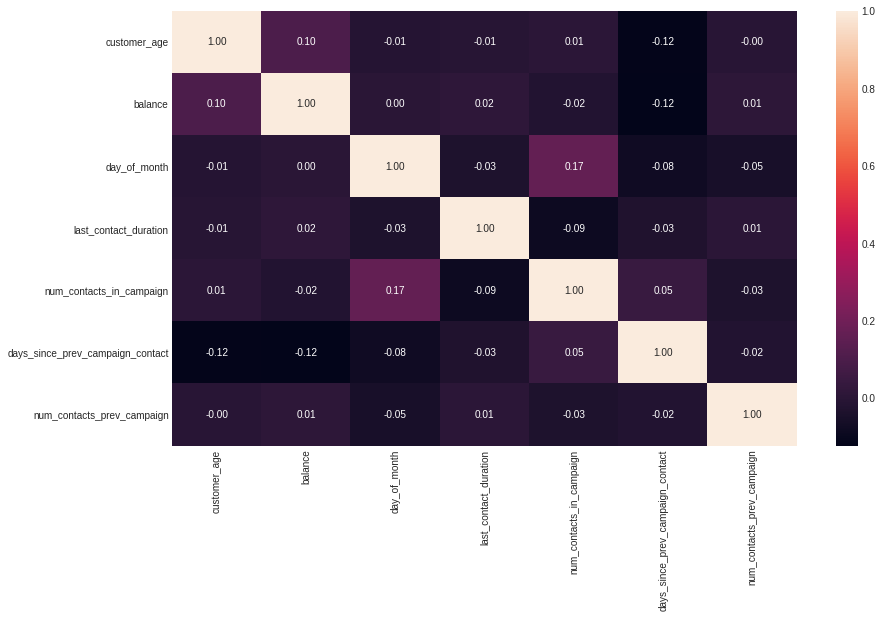

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(train[num_cols].corr(), annot=True,fmt='.2f')

**Next steps for EDA: Ideas and Suggestions.**

This was a basic EDA, to demonstrate its purpose. However the data contains a lot more hidden information. EDA has no end, and as we dig deeper into the data, we are sure to find more meaningful and interesting insights.

1. **Do a multivariate Feature Analysis**. Here we only have taken a look at each of the features and its relationship with the target variable, or relationship betwen two features. But can two or more features together influence the target more ?

2. **Dig deeper into more important features**. This can be done with the help of Feature Importance Scores. In the next section we will see how to create a baseline model and get feature importances.

# Metric and Baseline Model

**F1 Score**


In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.

The F1 score is the harmonic mean of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero. 

https://en.wikipedia.org/wiki/F1_score

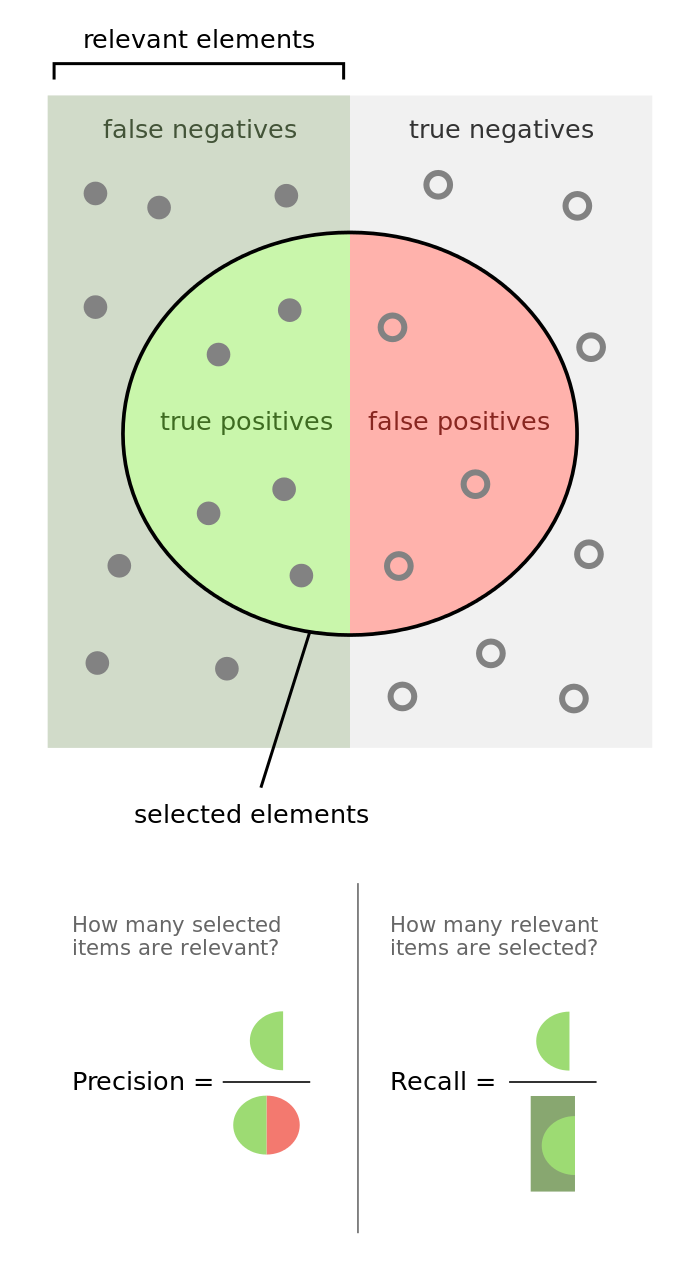


## **Baseline Models**

In [ ]:
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [ ]:
train[cat_cols] = train[cat_cols].fillna('mising')
train[num_cols] = train[num_cols].fillna(0)

In [ ]:
train.isnull().sum()

id                                  0
customer_age                        0
job_type                            0
marital                             0
education                           0
default                             0
balance                             0
housing_loan                        0
personal_loan                       0
communication_type                  0
day_of_month                        0
month                               0
last_contact_duration               0
num_contacts_in_campaign            0
days_since_prev_campaign_contact    0
num_contacts_prev_campaign          0
prev_campaign_outcome               0
term_deposit_subscribed             0
dtype: int64

In [ ]:
X = train[num_cols + cat_cols]
Y = train['term_deposit_subscribed']

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.99,random_state=42)

In [ ]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1)
model.fit(xtrain, ytrain,cat_features=cat_cols,eval_set=(xtest, ytest),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6272256	test: 0.6280714	best: 0.6280714 (0)	total: 92.4ms	remaining: 4.53s
1:	learn: 0.5750101	test: 0.5765516	best: 0.5765516 (1)	total: 128ms	remaining: 3.08s
2:	learn: 0.5297109	test: 0.5315697	best: 0.5315697 (2)	total: 140ms	remaining: 2.2s
3:	learn: 0.4909828	test: 0.4941210	best: 0.4941210 (3)	total: 158ms	remaining: 1.81s
4:	learn: 0.4588017	test: 0.4618202	best: 0.4618202 (4)	total: 172ms	remaining: 1.54s
5:	learn: 0.4322065	test: 0.4360142	best: 0.4360142 (5)	total: 184ms	remaining: 1.35s
6:	learn: 0.4079145	test: 0.4119084	best: 0.4119084 (6)	total: 198ms	remaining: 1.21s
7:	learn: 0.3874906	test: 0.3923056	best: 0.3923056 (7)	total: 210ms	remaining: 1.1s
8:	learn: 0.3698118	test: 0.3751100	best: 0.3751100 (8)	total: 225ms	remaining: 1.02s
9:	learn: 0.3542927	test: 0.3588594	best: 0.3588594 (9)	total: 244ms	remaining: 975ms
10:	learn: 0.3411499	test: 0.3464618	best: 0.3464618 (10)	total: 270ms	remaining: 956ms
11:	learn: 0.3263520	test: 0.3318537	best: 0.3318537 

In [ ]:
y_pred = model.predict(xtest)

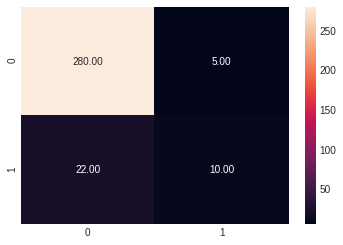

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,confusion_matrix
cm = confusion_matrix(ytest,y_pred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [ ]:
accuracy_score(ytest,y_pred)

0.9148264984227129

In [ ]:
f1_score(ytest,y_pred)

0.425531914893617

In [ ]:
test.isnull().sum()

id                                  0    
customer_age                        270  
job_type                            0    
marital                             81   
education                           0    
default                             0    
balance                             181  
housing_loan                        0    
personal_loan                       74   
communication_type                  0    
day_of_month                        0    
month                               0    
last_contact_duration               122  
num_contacts_in_campaign            45   
days_since_prev_campaign_contact    11123
num_contacts_prev_campaign          0    
prev_campaign_outcome               0    
dtype: int64

In [ ]:
test = test[X.columns]

In [ ]:
test[cat_cols] = test[cat_cols].fillna('missing')
test[num_cols] = test[num_cols].fillna(0)

In [ ]:
results = model.predict(test)

In [ ]:
ss.shape,test.shape

((13564, 2), (13564, 16))

In [ ]:
ss.head()

id  term_deposit_subscribed
0  id_17231  0                      
1  id_34508  0                      
2  id_44504  0                      
3  id_174    0                      
4  id_2115   0

In [ ]:
len(results)

13564

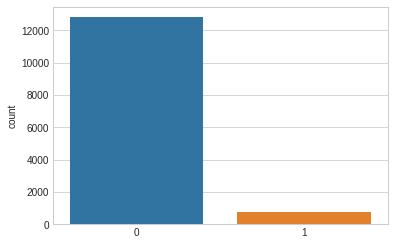

In [ ]:
sns.countplot(results)

In [ ]:
test['term_deposit_subscribed'] = results

In [ ]:
test.head()

customer_age  balance  ...  prev_campaign_outcome  term_deposit_subscribed
0  55.0          7136.0   ...  unknown                0                      
1  24.0          179.0    ...  unknown                0                      
2  46.0          143.0    ...  unknown                0                      
3  56.0          6023.0   ...  unknown                0                      
4  62.0          2913.0   ...  success                0                      

[5 rows x 17 columns]

In [ ]:
ss['term_deposit_subscribed'] = results

In [ ]:
ss.head()

id  term_deposit_subscribed
0  id_17231  0                      
1  id_34508  0                      
2  id_44504  0                      
3  id_174    0                      
4  id_2115   0

In [ ]:
ss['term_deposit_subscribed'].value_counts(normalize=True)

0    0.944191
1    0.055809
Name: term_deposit_subscribed, dtype: float64

In [ ]:
ss.to_csv('first.csv',index=False)

# Session -2 

In [14]:
features = cat_cols + num_cols

In [16]:
X = train[features]
Y = train[TARGET_COL]

In [17]:
X.isnull().sum()

job_type                            0    
marital                             150  
education                           0    
default                             0    
housing_loan                        0    
personal_loan                       149  
communication_type                  0    
month                               0    
prev_campaign_outcome               0    
customer_age                        619  
balance                             399  
day_of_month                        0    
last_contact_duration               311  
num_contacts_in_campaign            112  
days_since_prev_campaign_contact    25831
num_contacts_prev_campaign          0    
dtype: int64

In [18]:
X[num_cols] = X[num_cols].fillna(-999)
X[cat_cols] = X[cat_cols].fillna('missing')

In [21]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.85,stratify=train[TARGET_COL],random_state=42)

In [29]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1)
model.fit(xtrain, ytrain,cat_features=cat_cols,eval_set=(xtest, ytest),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6266692	test: 0.6265802	best: 0.6265802 (0)	total: 21ms	remaining: 1.03s
1:	learn: 0.5729713	test: 0.5725664	best: 0.5725664 (1)	total: 40.2ms	remaining: 965ms
2:	learn: 0.5289666	test: 0.5288162	best: 0.5288162 (2)	total: 64.6ms	remaining: 1.01s
3:	learn: 0.4912696	test: 0.4911783	best: 0.4911783 (3)	total: 96.6ms	remaining: 1.11s
4:	learn: 0.4585914	test: 0.4585231	best: 0.4585231 (4)	total: 123ms	remaining: 1.11s
5:	learn: 0.4305426	test: 0.4306624	best: 0.4306624 (5)	total: 159ms	remaining: 1.17s
6:	learn: 0.4066124	test: 0.4066292	best: 0.4066292 (6)	total: 178ms	remaining: 1.09s
7:	learn: 0.3858676	test: 0.3859222	best: 0.3859222 (7)	total: 198ms	remaining: 1.04s
8:	learn: 0.3682814	test: 0.3685789	best: 0.3685789 (8)	total: 226ms	remaining: 1.03s
9:	learn: 0.3532877	test: 0.3537162	best: 0.3537162 (9)	total: 245ms	remaining: 981ms
10:	learn: 0.3404754	test: 0.3408693	best: 0.3408693 (10)	total: 275ms	remaining: 975ms
11:	learn: 0.3279865	test: 0.3284017	best: 0.32840

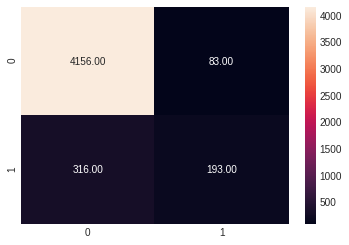

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,confusion_matrix
y_pred = model.predict(xtest)
cm = confusion_matrix(ytest,y_pred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [32]:
accuracy_score(ytest,y_pred)

0.9159646166807077

In [31]:
f1_score(ytest,y_pred)

0.49171974522292994

In [34]:
x_new = X.copy()
x_new = pd.get_dummies(x_new)

In [35]:
x_new.columns

Index(['customer_age', 'balance', 'day_of_month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'job_type_admin.', 'job_type_blue-collar',
       'job_type_entrepreneur', 'job_type_housemaid', 'job_type_management',
       'job_type_retired', 'job_type_self-employed', 'job_type_services',
       'job_type_student', 'job_type_technician', 'job_type_unemployed',
       'job_type_unknown', 'marital_divorced', 'marital_married',
       'marital_missing', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_no', 'default_yes', 'housing_loan_no', 'housing_loan_yes',
       'personal_loan_missing', 'personal_loan_no', 'personal_loan_yes',
       'communication_type_cellular', 'communication_type_telephone',
       'communication_type_unknown', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month

In [36]:
xtrain,xtest,ytrain,ytest = train_test_split(x_new,Y,train_size=0.85,stratify=train[TARGET_COL],random_state=42)

## DecisonTreeClassifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

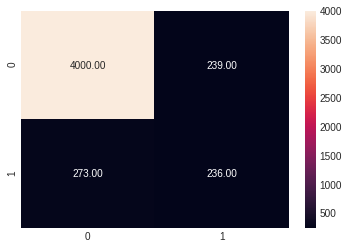

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)
y_pred = dt.predict(xtest)
cm = confusion_matrix(ytest,y_pred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [39]:
f1_score(ytest,y_pred)

0.4796747967479675

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
params = {"max_depth":[3,5,8,10],
          "class_weight":[{0:1,1:3},{0:0.5,1:1}],
          "max_features": randint(1, 9),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]
          }
clf = DecisionTreeClassifier(random_state=42)
search = RandomizedSearchCV(clf,param_distributions=params,cv=10)


In [70]:
search.fit(x_new,Y)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
           

In [71]:
search.best_params_

{'class_weight': {0: 0.5, 1: 1},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 8,
 'min_samples_leaf': 6}

In [72]:
dt = search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.5, 1: 1},
                       criterion='gini', max_depth=10, max_features=8,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

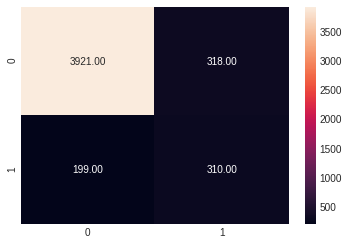

In [73]:
dt.fit(xtrain,ytrain)
y_pred = dt.predict(xtest)
cm = confusion_matrix(ytest,y_pred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [74]:
f1_score(ytest,y_pred)

0.5452946350043976

In [75]:
accuracy_score(ytest,y_pred)

0.891112047177759

In [79]:
test = test[X.columns]
test[cat_cols] = test[cat_cols].fillna("missing")
test[num_cols] = test[num_cols].fillna(0)
test_new = pd.get_dummies(test)
results = dt.predict(test_new)

In [80]:
ss.head()

id  term_deposit_subscribed
0  id_17231  0                      
1  id_34508  0                      
2  id_44504  0                      
3  id_174    0                      
4  id_2115   0

In [81]:
ss['term_deposit_subscribed'] = results

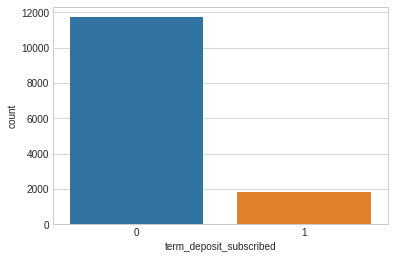

In [82]:
sns.countplot(ss['term_deposit_subscribed'])

In [83]:
ss.to_csv('DT.csv',index=False)

#### **hackathon Score : 	0.534638554216867**

## Starting  with Machine Learning Models

In [8]:
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

num_cols = [c for c in features if c not in cat_cols]

## Download Results

In [9]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

**Steps to Make a Baseline Classification Model**

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a classification Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

**1. Concating/Joining train and test datasets.**

In [10]:
train.shape,test.shape

((31647, 18), (13564, 17))

In [13]:
31647 + 13564

45211

In [12]:
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df.shape

(45211, 18)

In [14]:
df.head()

id  customer_age  ... prev_campaign_outcome term_deposit_subscribed
0  id_43823  28.0          ...  unknown               0.0                   
1  id_32289  34.0          ...  other                 0.0                   
2  id_10523  46.0          ...  unknown               0.0                   
3  id_43951  34.0          ...  unknown               0.0                   
4  id_40992  41.0          ...  unknown               0.0                   

[5 rows x 18 columns]

**2. Encoding categorical columns.**

There are multiple ways to encoded categorical variables. For the sake of simplicity, we will be using One-Hot Encoding.

In [15]:
df = pd.get_dummies(df,columns=cat_cols)
print(df.shape)

(45211, 53)


In [16]:
df.head()

id  ...  prev_campaign_outcome_unknown
0  id_43823  ...  1                            
1  id_32289  ...  0                            
2  id_10523  ...  1                            
3  id_43951  ...  1                            
4  id_40992  ...  1                            

[5 rows x 53 columns]

**3. Filling Null Values**

As seen earlier in our EDA, our dataset contains null values. There could be multiple ways to fill our Null Values, but for now we will fill it with a large negative random number say -999

In [17]:
df = df.fillna(-999)
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

**4. Split the processed dataset back into train and test datasets.**

The first train.shape[0] of df are rows that belong to train and the rest are those that belong to test

In [20]:
train_proc,test_proc = df[:train.shape[0]],df[train.shape[0]:].reset_index(drop=True)
features = [c for c in train_proc.columns if c not in [ID_COL,TARGET_COL]]

In [21]:
len(features)

51

**5. Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [23]:
trn,val = train_test_split(train_proc,train_size=0.8,random_state=42,stratify=train_proc[TARGET_COL])

#### Input to our model

In [24]:
X_trn,X_val = trn[features],val[features]

In [25]:
X_trn.shape,X_val.shape

((25317, 51), (6330, 51))

#### Output to our Model

In [26]:
y_trn,y_val = trn[TARGET_COL],val[TARGET_COL]
y_trn.shape,y_val.shape

((25317,), (6330,))

##### Features for the test data that we will be predicting

In [28]:
X_test = test_proc[features]
X_test.shape

(13564, 51)

**6. Fit a classification Model on train, check its results on validation set.**

**Logistic Regression**

In [27]:
X_trn.head()

customer_age  ...  prev_campaign_outcome_unknown
14983  22.0          ...  1                            
21390  55.0          ...  1                            
8803   54.0          ...  1                            
13750  40.0          ...  0                            
12331  54.0          ...  0                            

[5 rows x 51 columns]

**Data Normalization**

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
X_trn.shape

(25317, 51)

In [31]:
X_trn[:,0]

array([0.01495793, 0.24230832, 0.23541892, ..., 0.18719308, 0.25608713,
       0.0976308 ])

In [32]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.4774436090225564

**0.47, not bad. Much better than our rule based classifier of score 30**

**Submitting on the Leaderboard**

In [33]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_logistic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.463**, again near our validation score, its nice we are improving :D

##### **6B. Decision Tree**

A Decision Tree is a flowchart like structure, where each node represents a decision, each branch represents an outcome of the decision, and each terminal node provides a prediction / label.

https://courses.analyticsvidhya.com/courses/getting-started-with-decision-trees

In [35]:
clf = DecisionTreeClassifier(random_state = 42)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.48934606906686257

**Submitting on the Leaderboard**

In [36]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_decision_tree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.4812**, slight improvement over our Logistic Regression scores

# **Hyperparameter Tuning**

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:
```
max_depth: [6, 9, 12, 15]
learning_rate: [0.0001, 0.005, 0.01, 0.05]
```

etc.

## **1. Grid Search**

In grid search we try all possible combinations from the values of hyperparameters provided, to find the optimal hyper-parameter combination. However as the number of hyperparameters and their possible values grows, doing a grid search becomes infeasible.

Consider there are 5 hyperparameters to tune, and each of them 5 have different possible values.

Then total possible combinations of hyperparameters will be:

5 x 5 x 5 x 5 x 5 = 3125.

So you will have to wait for your model to run 3125 times, before getting the optimal set of hyperparameters.

If you still think you want to run it these many times, you are most welcome :)


# **2. Random Search**

In random search we will run our model only a fixed number of times, say 10, and among these 10 runs we will return the best hyper-parameter combination. Yes, you are right, this may not be the optimal hyper-parameter combination. But, it saves much more time, so we will go for random search.

In [37]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}],
    'random_state':[1,42,200]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 4},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 2,
 'random_state': 1}

In [38]:
optimal_parameters = {'class_weight': {0: 1, 1: 4},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 2,
 'random_state': 1}

In [40]:
clf = DecisionTreeClassifier(**optimal_parameters)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.5927835051546392

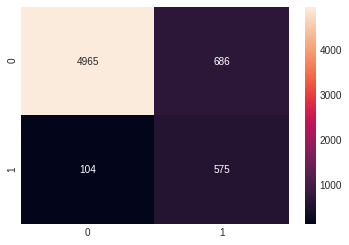

In [43]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_val,preds_val)
sns.heatmap(cm,annot=True,fmt='g')

In [44]:
accuracy_score(y_val,preds_val)

0.8751974723538705

**Making a submmission on the improved model**

In [45]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name = 'hacklive_dt_tuned_random.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.5873297809354648**

# **Validation Strategy.**

**Problems with simple train_test_split validation**

* We are not using complete 100 % of the dataset for training. More data implies more performance, if the data quality is good.

* We are not using complete 100 % of the dataset for validation. Our validation now is biased towards the validation set we have got through train_test_split. What if the test set is different from the validation set ?

## **K-Fold Validation**

K Fold validation splits the dataset into K-parts or K-splits.

Suppose we are performing a 5-fold validation. Thus we split the training dataset into 5 parts. Each of these will contain 20 % of the dataset.


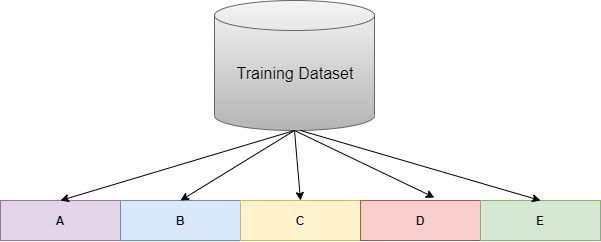

Now for each of these parts, we take them as validation one by one and rest of the parts for training. The unshaded or white box, represents the part among A, B, C, D, and E, that we take for validation. Rest are used for training in that particular fold.
Then we make two predictions (shown in the right hand side of the diagram):

**1. Predictions for the validation set:** This is also known as out-of-fold prediction.

**2. Predictions for the test set:** This is the dataset for which we need to submit our predictions to AV.

Finally if we combine the predictions for each of these folds we get OOFs or Out-of-Folds predictions. This is the prediction for the entire dataset. We can now see the performance our classifier on the entire training set.

Also we take the mean of the test predictions for each fold, and get our final test_predictions. We then need to round it to 0 or 1, since our metric demands we submit a discrete output, ie. no probabilities. 

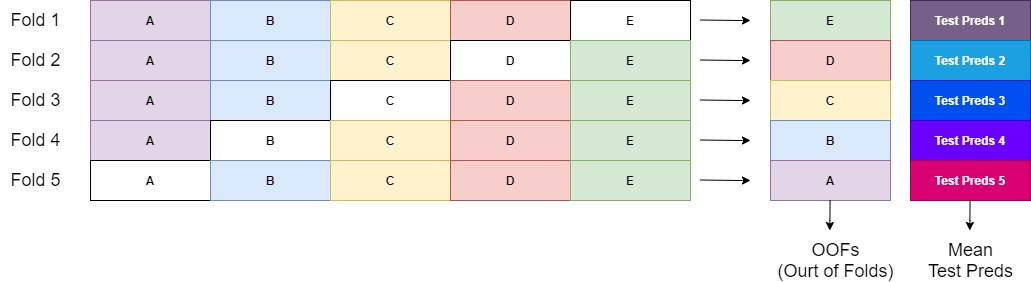

## **Stratified K-Fold.**

One obvious problem with normal KFold, is that each in each fold the distribution of classes in the validation set, will be not be same. This is a big problem with imbalanced datasets. 

In our above example its possible that in any of the splits we could have could have a validation set with no positive examples. 

To overcome this problem we will use Stratified-KFold Validation. StratifiedKFold ensures that each of the splits have same proportion of examples of each class.

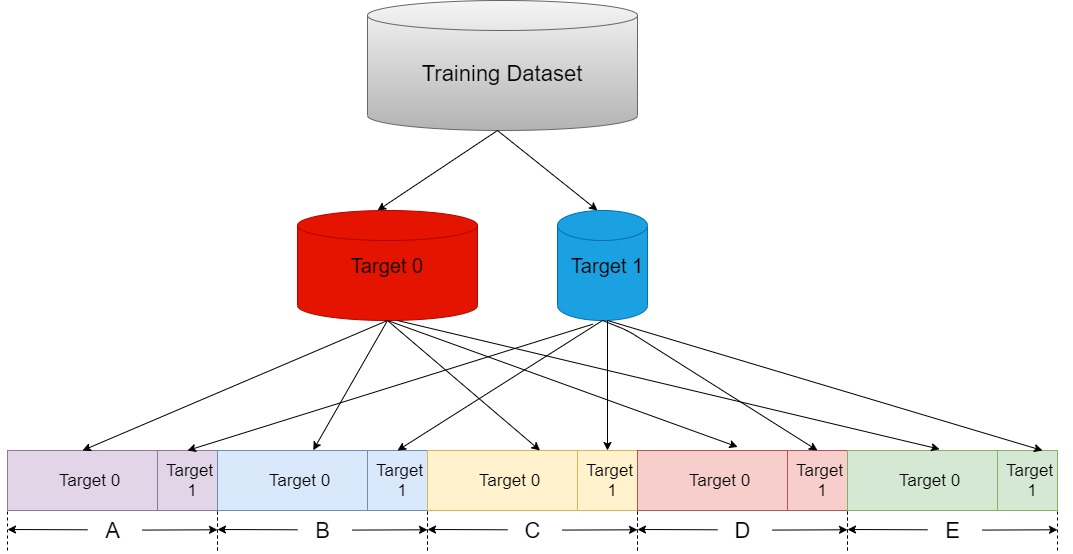

**Function to Run KFold**

In [46]:
from sklearn.model_selection import StratifiedKFold
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

**KFold on Decision Tree**

In [47]:
target = train[TARGET_COL]
optimal_parameters = {'class_weight': {0: 1, 1: 4},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 2,
 'random_state': 1}

clf = DecisionTreeClassifier(**optimal_parameters)

In [48]:
dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.5789990186457311

------------- Fold 2 -------------

F1 score for validation set is 0.6157979580870501

------------- Fold 3 -------------

F1 score for validation set is 0.5949679329057721

------------- Fold 4 -------------

F1 score for validation set is 0.5935483870967743

------------- Fold 5 -------------

F1 score for validation set is 0.5801980198019803


F1 score for oofs is 0.5922904344279013


**Submitting on the Leaderboard**

In [49]:
dt_preds_rounded = dt_preds.round()
download_preds(dt_preds_rounded, file_name = 'hacklive_dt_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.5872442839951866.** did not improve much

# **Gradient Boosting**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

 ## **LightGBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel and GPU learning.

* Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

In [50]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier(random_state=42)
lgb_oofs,lgb_preds = run_clf_kfold(clf,train_proc,test_proc,features)


------------- Fold 1 -------------

F1 score for validation set is 0.5797101449275361

------------- Fold 2 -------------

F1 score for validation set is 0.5985518905872887

------------- Fold 3 -------------

F1 score for validation set is 0.5746753246753248

------------- Fold 4 -------------

F1 score for validation set is 0.5987055016181231

------------- Fold 5 -------------

F1 score for validation set is 0.5623471882640587


F1 score for oofs is 0.5828478964401295


**Submitting on the Leaderboard**

In [51]:
lgb_preds_rounded = lgb_preds.round()
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.5746268656716418.** score did not improve

In [52]:
preds = np.array([0.2, 0.4, 0.35, 0.7, 0.21])
preds.round()

array([0., 0., 0., 1., 0.])

### **Hacking F1_Score or Threshold optimization**

Rounding off means you are selecting a threshold of 0.5. Any predictions with probabilities greater than or equal to 0.5 will be rounded to 1, rest will be rounded to 0.

But is 0.5 the best threshold to get an optimal F1-score ?

Lets verify it ourselves by running all threholds from 0.01,0.02 to 0.99.

In [53]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.19371593276447588
Threshold 0.01: 0.402852897473997
Threshold 0.02: 0.480711743772242
Threshold 0.03: 0.5229929851909586
Threshold 0.04: 0.5470043439062371
Threshold 0.05: 0.5652543814871533
Threshold 0.06: 0.5774080560420315
Threshold 0.07: 0.588689407540395
Threshold 0.08: 0.5969027765050857
Threshold 0.09: 0.6052557748059478
Threshold 0.1: 0.6131859756097561
Threshold 0.11: 0.6179240702980872
Threshold 0.12: 0.6228182624987674
Threshold 0.13: 0.627392044885282
Threshold 0.14: 0.6309039087947882
Threshold 0.15: 0.6322633914748684
Threshold 0.16: 0.6337276248298963
Threshold 0.17: 0.6366436537440254
Threshold 0.18: 0.6390710676271368
Threshold 0.19: 0.6401391606871059
Threshold 0.2: 0.6435894609194136
Threshold 0.21: 0.6456798392498325
Threshold 0.22: 0.6452050152490681
Threshold 0.23: 0.6462135036496351
Threshold 0.24: 0.6475419317524581
Threshold 0.25: 0.6483889865260692
Threshold 0.26: 0.6486165538534615
Threshold 0.27: 0.6495130455693159
Threshold 0.28: 0.64847746

**Find Optimal Threshold**

In [54]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.27


0.6495130455693159

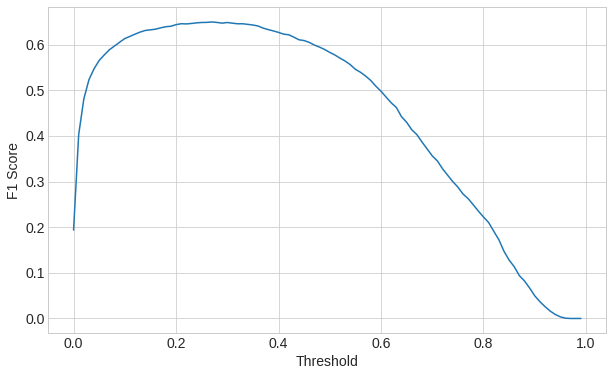

In [55]:
optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
f1_score(target, (lgb_oofs > optimal_thresh) * 1)

**Submitting on the Leaderboard**

In [56]:
optimal_thresh

0.27

In [57]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_threshold_optimized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6616334934797529.** the score has improved a lot with threshold optimization.

### **Tuning LightGBM**

* Early Stopping: Stopping the model training, when the model starts to overfit
  * How do we know if model is overfitting ?
* HyperParameter Optimization.
  * Is random search the best way to go ?

**Simple Function to Run Gradient Boosting**

Let's make a simple function to call gradient boosting and get our oofs and predictions. Rather than copying and pasting the same code again and again/

In [59]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

**Manual Tuning. Choosing Hyperparameters to Tune**


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.167919
[200]	valid_0's binary_logloss: 0.165527
[300]	valid_0's binary_logloss: 0.165441
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.165302

F1 score for validation set is 0.5844897959183674

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.165002
[200]	valid_0's binary_logloss: 0.159994
[300]	valid_0's binary_logloss: 0.1601
Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.159718

F1 score for validation set is 0.5933170334148329

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.169094
[200]	valid_0's binary_logloss: 0.164644
[300]	valid_0's binary_logloss: 0.163774
[400]	valid_0's binary_logloss: 0.163958
Early stopping, best iteration is:
[327]	

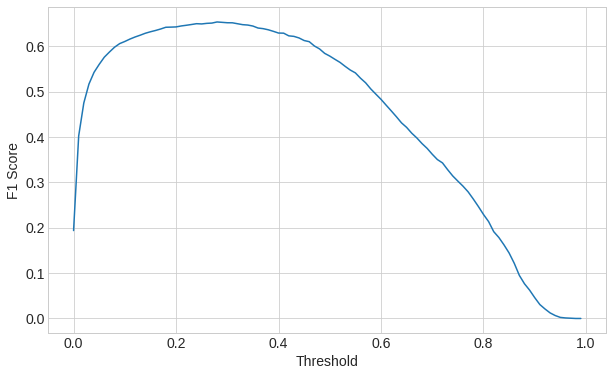

In [60]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Tuning Learning Rate**


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.191005
[400]	valid_0's binary_logloss: 0.173029
[600]	valid_0's binary_logloss: 0.167575
[800]	valid_0's binary_logloss: 0.165652
[1000]	valid_0's binary_logloss: 0.165193
[1200]	valid_0's binary_logloss: 0.165259
Early stopping, best iteration is:
[1073]	valid_0's binary_logloss: 0.165143

F1 score for validation set is 0.5901639344262296

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.189294
[400]	valid_0's binary_logloss: 0.169347
[600]	valid_0's binary_logloss: 0.162194
[800]	valid_0's binary_logloss: 0.159335
[1000]	valid_0's binary_logloss: 0.158345
[1200]	valid_0's binary_logloss: 0.157803
[1400]	valid_0's binary_logloss: 0.157511
[1600]	valid_0's binary_logloss: 0.157439
[1800]	valid_0's binary_logloss: 0.157614
Early stopping, best iteration is:
[1659]	valid_0's 

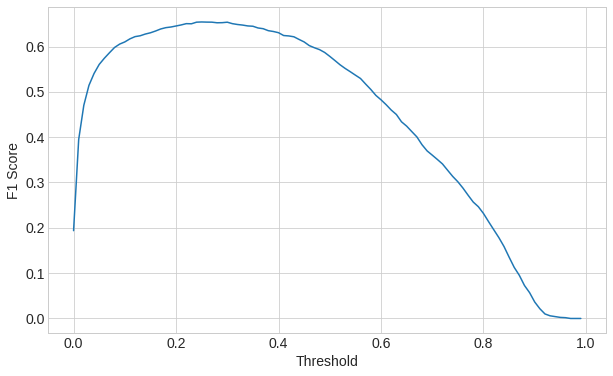

In [61]:
clf = LGBMClassifier(n_estimators = 2000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 2)
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

# Hyperparameters

In [64]:
lgbm_parameters = {'n_estimators':[1000,1500,2000],
                  'learning_rate':[0.01,0.05,0.001],
                  'colsample_bytree':[0.76,0.65,0.55],
                  'random_state':[1,20,42]}
lgbm = LGBMClassifier()
search = RandomizedSearchCV(lgbm,lgbm_parameters,cv = 5, n_iter=100)
search.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

KeyboardInterrupt: ignored

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/


------------- Fold 1 -------------
0:	learn: 0.6813125	test: 0.6812521	best: 0.6812521 (0)	total: 66.6ms	remaining: 3m 19s
200:	learn: 0.2051442	test: 0.2051839	best: 0.2051839 (200)	total: 3s	remaining: 41.7s
400:	learn: 0.1820961	test: 0.1849985	best: 0.1849985 (400)	total: 5.94s	remaining: 38.5s
600:	learn: 0.1714202	test: 0.1779313	best: 0.1779313 (600)	total: 8.93s	remaining: 35.7s
800:	learn: 0.1636347	test: 0.1733997	best: 0.1733997 (800)	total: 11.9s	remaining: 32.6s
1000:	learn: 0.1579302	test: 0.1706201	best: 0.1706201 (1000)	total: 14.8s	remaining: 29.6s
1200:	learn: 0.1528147	test: 0.1683943	best: 0.1683932 (1198)	total: 17.7s	remaining: 26.5s
1400:	learn: 0.1484515	test: 0.1668977	best: 0.1668977 (1400)	total: 20.6s	remaining: 23.5s
1600:	learn: 0.1445013	test: 0.1658762	best: 0.1658762 (1600)	total: 23.5s	remaining: 20.6s
1800:	learn: 0.1406907	test: 0.1652143	best: 0.1652061 (1796)	total: 26.5s	remaining: 17.6s
2000:	learn: 0.1374177	test: 0.1647245	best: 0.1647245 (200

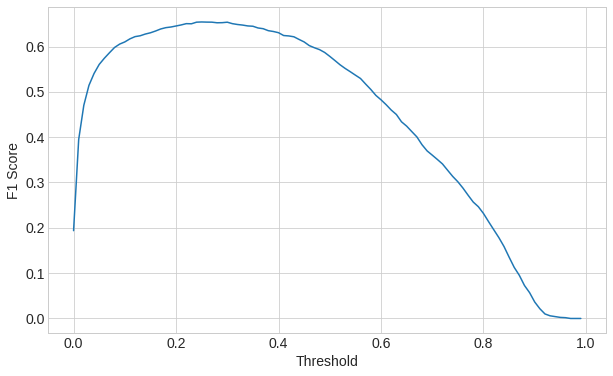

In [65]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [66]:
cb_preds_rounded = (cb_preds > optimal_thresh) * 1
download_preds(cb_preds_rounded, file_name = 'hacklive_cb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6620689655172414** The score has improved a bit

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/


------------- Fold 1 -------------
[0]	validation_0-error:0.097788
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.077409
[400]	validation_0-error:0.080411
Stopping. Best iteration:
[205]	validation_0-error:0.077251


F1 score for validation set is 0.5880370682392586

------------- Fold 2 -------------
[0]	validation_0-error:0.097156
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.079305
[400]	validation_0-error:0.079147
Stopping. Best iteration:
[360]	validation_0-error:0.077409


F1 score for validation set is 0.5983606557377049

------------- Fold 3 -------------
[0]	validation_0-error:0.099226
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.086428
[400]	validation_0-error:0.083109
[600]	validation_0-error:0.083425
Stopping. Best iteration:
[515]	validation_0-error:0.081845


F1 score for validation set is 0.5711920529801325

------------- Fold 4

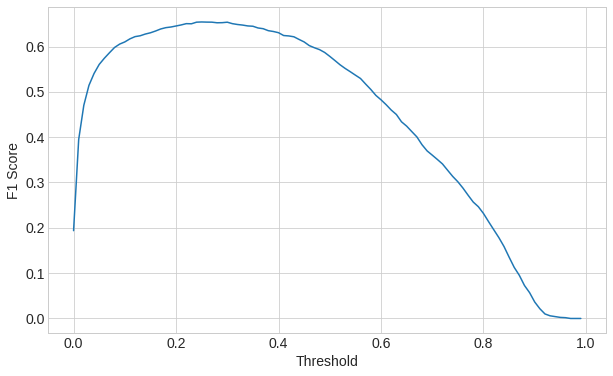

In [67]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')


------------- Fold 1 -------------
[0]	validation_0-error:0.089731
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.078989
Stopping. Best iteration:
[170]	validation_0-error:0.077409


F1 score for validation set is 0.5761245674740484

------------- Fold 2 -------------
[0]	validation_0-error:0.087046
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.078831
[400]	validation_0-error:0.078989
Stopping. Best iteration:
[237]	validation_0-error:0.077725


F1 score for validation set is 0.5851602023608768

------------- Fold 3 -------------
[0]	validation_0-error:0.0918
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.083742
[400]	validation_0-error:0.082951
Stopping. Best iteration:
[292]	validation_0-error:0.081529


F1 score for validation set is 0.5604770017035775

------------- Fold 4 -------------
[0]	validation_0-error:0.089114
Will train until valida

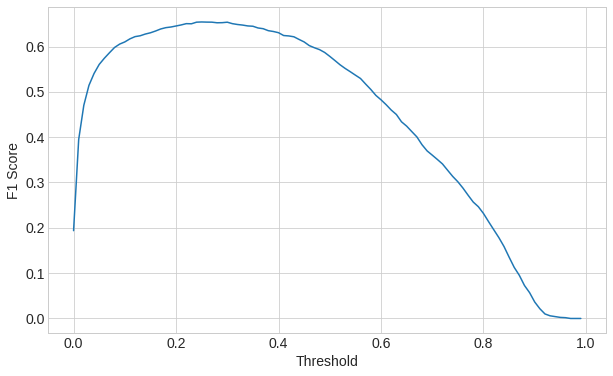

In [70]:
clf = XGBClassifier(n_estimators = 2000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=42,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [71]:
xgb_preds_rounded = (xgb_preds > optimal_thresh) * 1
download_preds(xgb_preds_rounded, file_name = 'hacklive_xgbb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6518105849582172.** Accuracy has decreased but it remains almost similar to validation score

# **Feature Engineering**

* What does a model know about a sample ?

* What the model does not know about the sample ?

* How do we provide that unknown information to the model ?


***Feature Engineering is one of the biggest difference maker in any ML competition.*** 

<br>
<br>

**Helper Functions**

In [72]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [73]:
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [74]:
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

In [75]:
train.head()

id  customer_age  ... prev_campaign_outcome term_deposit_subscribed
0  id_43823  28.0          ...  unknown               0                     
1  id_32289  34.0          ...  other                 0                     
2  id_10523  46.0          ...  unknown               0                     
3  id_43951  34.0          ...  unknown               0                     
4  id_40992  41.0          ...  unknown               0                     

[5 rows x 18 columns]

In [76]:
df, features = join_df(train, test)

In [77]:
df.head()

id  customer_age  ... prev_campaign_outcome term_deposit_subscribed
0  id_43823  28.0          ...  unknown               0.0                   
1  id_32289  34.0          ...  other                 0.0                   
2  id_10523  46.0          ...  unknown               0.0                   
3  id_43951  34.0          ...  unknown               0.0                   
4  id_40992  41.0          ...  unknown               0.0                   

[5 rows x 18 columns]

In [78]:
df.shape

(45211, 18)

In [82]:
df, features = join_df(train, test)

### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

#### No NaN filling required.

In [83]:
df.isnull().sum()[df.isnull().sum() > 0]

customer_age                        889  
balance                             580  
last_contact_duration               433  
num_contacts_in_campaign            157  
days_since_prev_campaign_contact    36954
term_deposit_subscribed             13564
dtype: int64

In [84]:
df.head()

id  customer_age  ...  prev_campaign_outcome  term_deposit_subscribed
0  id_43823  28.0          ...  0                      0.0                    
1  id_32289  34.0          ...  1                      0.0                    
2  id_10523  46.0          ...  0                      0.0                    
3  id_43951  34.0          ...  0                      0.0                    
4  id_40992  41.0          ...  0                      0.0                    

[5 rows x 18 columns]

In [85]:
df['job_type'].value_counts(normalize=True)

1     0.215257
0     0.209197
2     0.168034
6     0.114375
3     0.091880
4     0.050076
9     0.034925
5     0.032890
11    0.028820
8     0.027427
7     0.020747
10    0.006370
Name: job_type, dtype: float64

In [86]:
df['job_type'].map(df['job_type'].value_counts(normalize=True))

0        0.209197
1        0.215257
2        0.168034
3        0.091880
4        0.215257
           ...   
45206    0.209197
45207    0.215257
45208    0.215257
45209    0.114375
45210    0.168034
Name: job_type, Length: 45211, dtype: float64

In [89]:
def get_frequency_features(df, cols):

  df[[c + '_freq' for c in cols]] = df[cols].apply(lambda x: x.map(x.value_counts(normalize=True)))
  
  return df

In [90]:
freq_cols = [c for c in df.columns if (train[c].nunique() > 10) and (train[c].nunique() < 50)]
freq_cols

['job_type',
 'day_of_month',
 'month',
 'num_contacts_in_campaign',
 'num_contacts_prev_campaign']

In [91]:
df = get_frequency_features(df, freq_cols)
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

# Apply LightGBM


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.205458
[400]	valid_0's binary_logloss: 0.180558
[600]	valid_0's binary_logloss: 0.170463
[800]	valid_0's binary_logloss: 0.166534
[1000]	valid_0's binary_logloss: 0.164775
[1200]	valid_0's binary_logloss: 0.163737
[1400]	valid_0's binary_logloss: 0.163092
[1600]	valid_0's binary_logloss: 0.162731
[1800]	valid_0's binary_logloss: 0.162783
Early stopping, best iteration is:
[1725]	valid_0's binary_logloss: 0.162697

F1 score for validation set is 0.5839536807278743

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.20425
[400]	valid_0's binary_logloss: 0.17895
[600]	valid_0's binary_logloss: 0.168815
[800]	valid_0's binary_logloss: 0.164977
[1000]	valid_0's binary_logloss: 0.163323
[1200]	valid_0's binary_logloss: 0.161824
[1400]	valid_0's binary_logloss: 0.161171
[1600]	valid

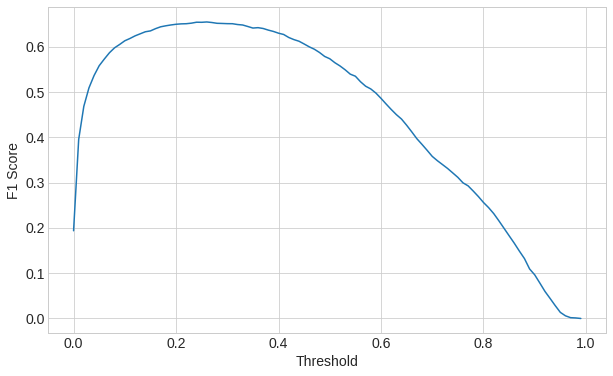

In [92]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.4,
                        reg_alpha = 1,
                        reg_lambda = 1
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

## **Interaction Features**

Can any two features be combined to make more sense in the given dataset ?

In [94]:
df.head()

id  ...  num_contacts_prev_campaign_freq
0  id_43823  ...  0.817367                       
1  id_32289  ...  0.061313                       
2  id_10523  ...  0.817367                       
3  id_43951  ...  0.817367                       
4  id_40992  ...  0.817367                       

[5 rows x 23 columns]

In [93]:
df[['month', 'day_of_month']].head()

month  day_of_month
0  0      26          
1  1      18          
2  2      5           
3  3      20          
4  3      13

In [96]:
df['month_and_day_of_month'] = pd.factorize(df['month'].astype('str') + df['day_of_month'].astype('str'))[0]

In [97]:
df['month_and_day_of_month']

0        0  
1        1  
2        2  
3        3  
4        4  
        ..  
45206    139
45207    41 
45208    108
45209    4  
45210    92 
Name: month_and_day_of_month, Length: 45211, dtype: int64

In [98]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [99]:
train_proc.head()

id  ...  month_and_day_of_month
0  id_43823  ...  0                     
1  id_32289  ...  1                     
2  id_10523  ...  2                     
3  id_43951  ...  3                     
4  id_40992  ...  4                     

[5 rows x 24 columns]


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207034
[400]	valid_0's binary_logloss: 0.179554
[600]	valid_0's binary_logloss: 0.169858
[800]	valid_0's binary_logloss: 0.165635
[1000]	valid_0's binary_logloss: 0.163723
[1200]	valid_0's binary_logloss: 0.162504
[1400]	valid_0's binary_logloss: 0.16176
[1600]	valid_0's binary_logloss: 0.161409
[1800]	valid_0's binary_logloss: 0.161364
[2000]	valid_0's binary_logloss: 0.161416
Early stopping, best iteration is:
[1664]	valid_0's binary_logloss: 0.161346

F1 score for validation set is 0.582716049382716

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.204002
[400]	valid_0's binary_logloss: 0.176246
[600]	valid_0's binary_logloss: 0.166566
[800]	valid_0's binary_logloss: 0.162407
[1000]	valid_0's binary_logloss: 0.160111
[1200]	valid_0's binary_logloss: 0.158753
[1400]	valid

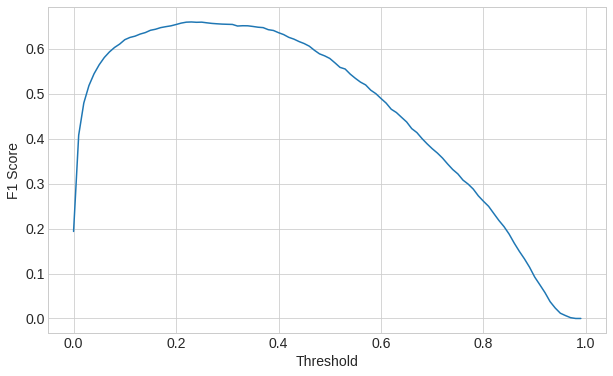

In [100]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [101]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6684491978609627.** Score after Feature Engineering

# New Feature

In [102]:
df = get_frequency_features(df, ['month_and_day_of_month'])
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [103]:
df.head()

id  customer_age  ...  month_and_day_of_month  month_and_day_of_month_freq
0  id_43823  28.0          ...  0                       0.001017                   
1  id_32289  34.0          ...  1                       0.015704                   
2  id_10523  46.0          ...  2                       0.009776                   
3  id_43951  34.0          ...  3                       0.008693                   
4  id_40992  41.0          ...  4                       0.022163                   

[5 rows x 25 columns]


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207293
[400]	valid_0's binary_logloss: 0.178549
[600]	valid_0's binary_logloss: 0.169959
[800]	valid_0's binary_logloss: 0.165109
[1000]	valid_0's binary_logloss: 0.163458
[1200]	valid_0's binary_logloss: 0.161927
[1400]	valid_0's binary_logloss: 0.161026
[1600]	valid_0's binary_logloss: 0.160614
[1800]	valid_0's binary_logloss: 0.160538
[2000]	valid_0's binary_logloss: 0.160391
[2200]	valid_0's binary_logloss: 0.16044
[2400]	valid_0's binary_logloss: 0.160494
Early stopping, best iteration is:
[2075]	valid_0's binary_logloss: 0.160337

F1 score for validation set is 0.5905383360522023

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.203244
[400]	valid_0's binary_logloss: 0.174633
[600]	valid_0's binary_logloss: 0.166271
[800]	valid_0's binary_logloss: 0.161494
[1000]	vali

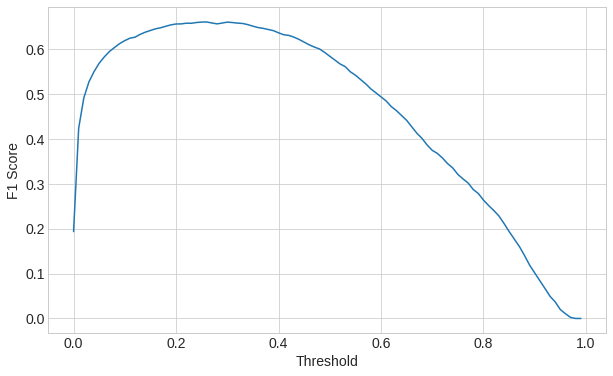

In [104]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [105]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6796116504854369.** with frequency feature introduced the scores increased

# Grouping Features

In [106]:
df['mean_age_for_customer_on_month_and_day_of_month'] = df.groupby('month_and_day_of_month')['customer_age'].transform('mean')
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [107]:
df.head()

id  ...  mean_age_for_customer_on_month_and_day_of_month
0  id_43823  ...  38.755556                                      
1  id_32289  ...  41.185345                                      
2  id_10523  ...  38.647196                                      
3  id_43951  ...  36.910256                                      
4  id_40992  ...  38.961382                                      

[5 rows x 26 columns]


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.202053
[400]	valid_0's binary_logloss: 0.17671
[600]	valid_0's binary_logloss: 0.16704
[800]	valid_0's binary_logloss: 0.163316
[1000]	valid_0's binary_logloss: 0.161244
[1200]	valid_0's binary_logloss: 0.160354
[1400]	valid_0's binary_logloss: 0.160107
[1600]	valid_0's binary_logloss: 0.159898
[1800]	valid_0's binary_logloss: 0.159865
[2000]	valid_0's binary_logloss: 0.159911
Early stopping, best iteration is:
[1705]	valid_0's binary_logloss: 0.159833

F1 score for validation set is 0.5842880523731587

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.199161
[400]	valid_0's binary_logloss: 0.173862
[600]	valid_0's binary_logloss: 0.164341
[800]	valid_0's binary_logloss: 0.160841
[1000]	valid_0's binary_logloss: 0.158901
[1200]	valid_0's binary_logloss: 0.158041
[1400]	valid

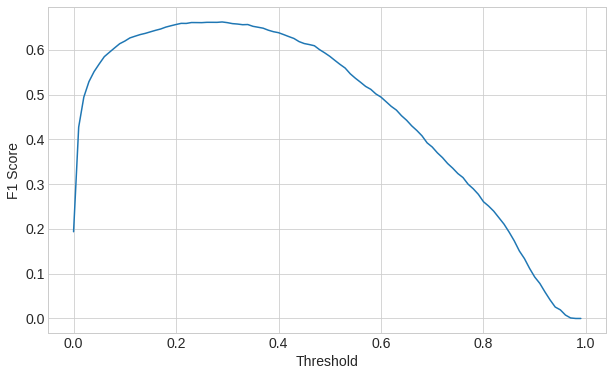

In [108]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [109]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq_grouped.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.6737891737891737.** grouping features decreased  the scores

# **Ensembling**

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.



* What are our best performing algorithms ?
* How do we combine these algorithms to get a better performance ?

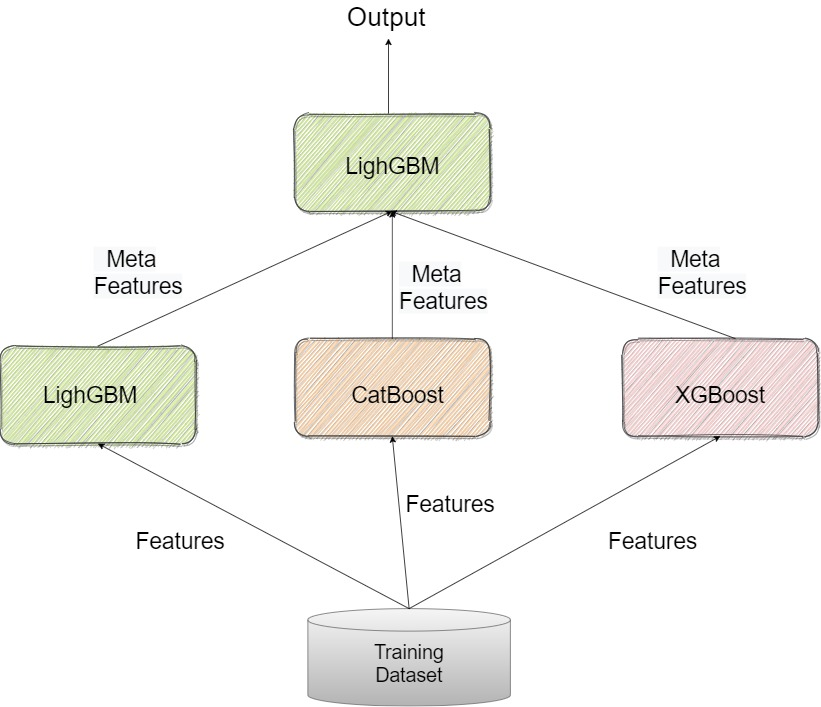

https://courses.analyticsvidhya.com/courses/ensemble-learning-and-ensemble-learning-techniques

In [110]:
train_new = train[[ID_COL, TARGET_COL]]
test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [111]:
features

['lgb', 'cb', 'xgb']

In [112]:
train_new

id  term_deposit_subscribed       lgb        cb       xgb
0      id_43823  0                        0.025843  0.006194  0.012001
1      id_32289  0                        0.003671  0.009816  0.060032
2      id_10523  0                        0.005003  0.006234  0.016321
3      id_43951  0                        0.000446  0.000392  0.003057
4      id_40992  0                        0.000656  0.000989  0.003222
...         ... ..                             ...       ...       ...
31642  id_27290  0                        0.003598  0.001943  0.007206
31643  id_20428  0                        0.000653  0.000254  0.000451
31644  id_44679  0                        0.000400  0.000259  0.000430
31645  id_4841   0                        0.020702  0.025916  0.026732
31646  id_1723   0                        0.017854  0.024604  0.018544

[31647 rows x 5 columns]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.1673
[400]	valid_0's binary_logloss: 0.157777
[600]	valid_0's binary_logloss: 0.157382
[800]	valid_0's binary_logloss: 0.157528
Early stopping, best iteration is:
[648]	valid_0's binary_logloss: 0.157359

F1 score for validation set is 0.624512099921936

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.164807
[400]	valid_0's binary_logloss: 0.154991
[600]	valid_0's binary_logloss: 0.154382
Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.154372

F1 score for validation set is 0.6283941039565555

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.167208
[400]	valid_0's binary_logloss: 0.158414
[600]	valid_0's binary_logloss: 0.158251
Early stopping, best iteration is:
[470]	v

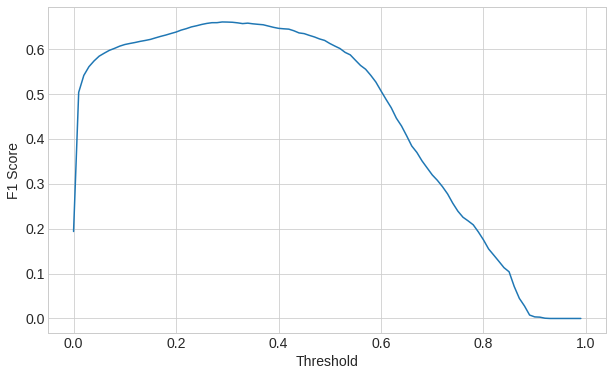

In [113]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.75,
                        reg_alpha=1,
                        reg_lambda=1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_new, test_new, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [114]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_stacked.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Your score for this submission is : 0.67248322147651.** Scores did not improve much